<a href="https://colab.research.google.com/github/iamdkshah/4thAssignAPI/blob/master/D_S_Project_23106359.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up : Mounting Google Drive and importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Install required packages
!pip install numpy pandas matplotlib seaborn optuna shap xgboost lightgbm tensorflow --quiet

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import time
import joblib
import json

# ML libraries
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# DL libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Dataset


In [22]:
# Cell 2 – Data Loading
import pandas as pd

# 1) Read in the CSV, parsing the Timestamp column
data_path = 'https://raw.githubusercontent.com/iamdkshah/Data_Science_Project_23106359/refs/heads/main/project_dataset.csv'
df = pd.read_csv(data_path, parse_dates=['Timestamp'])

# 2) Inspect raw column names and shape
print("Raw columns:", df.columns.tolist())
print("Data shape:", df.shape)

# 3) Preview first five rows
display(df.head())


Raw columns: ['Timestamp', 'Latitude', 'Longitude', 'GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)', 'Temp (°C)', 'RH (%)', 'Pressure (hPa)', 'Dew Point (°C)', 'Wind Speed (m/s)', 'Cloud Type', 'Solar Zenith Angle (°)', 'Target_GHI_NextHour (W/m²)']
Data shape: (1000, 14)


,Timestamp,Latitude,Longitude,GHI (W/m²),DNI (W/m²),DHI (W/m²),Temp (°C),RH (%),Pressure (hPa),Dew Point (°C),Wind Speed (m/s),Cloud Type,Solar Zenith Angle (°),Target_GHI_NextHour (W/m²)
0,1998-01-01 00:30:00,39.754943,-104.928739,341.581118,380.326236,72.649858,11.916165,35.728528,1010.482264,10.250311,3.278999,Clear,72.818352,383.384506
1,1998-01-01 01:00:00,39.832204,-105.039324,177.789175,300.146084,-34.446156,20.988743,98.138223,1009.356547,19.228097,3.180614,Cumulus,80.395158,654.211173
2,1998-01-01 01:30:00,39.880517,-104.736875,383.384506,349.160733,136.490584,25.183423,39.959014,1008.698430,21.821219,4.424296,Clear,30.029383,562.802620
3,1998-01-01 02:00:00,39.870209,-105.075542,654.211173,215.090519,502.119208,13.275915,67.850579,1011.101321,11.042622,2.273316,Overcast,69.173049,341.691203
4,1998-01-01 02:30:00,39.739962,-105.010037,562.802620,807.605770,-8.260897,16.168259,56.339117,1017.752069,13.354326,5.219018,Cumulus,73.775065,509.841850


In [23]:
# Cell 3 — Quick Initial EDA (raw look)

import numpy as np

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nDtypes:")
print(df.dtypes)

print("\nMissing values (top 15):")
print(df.isna().sum().sort_values(ascending=False).head(15))

# Basic stats (numeric)
print("\nNumeric summary (head):")
print(df.select_dtypes(include=np.number).describe().T.head(12))

# Peek at first rows
print("\nHead:")
display(df.head())

# Identify timestamp column (if present) and show time span
ts_col = "Timestamp" if "Timestamp" in df.columns else ("timestamp" if "timestamp" in df.columns else None)
if ts_col:
    dft = df.dropna(subset=[ts_col]).sort_values(ts_col)
    print("\nTime span:", dft[ts_col].min(), "→", dft[ts_col].max())
    # check cadence (median step)
    if np.issubdtype(dft[ts_col].dtype, np.datetime64) and len(dft) > 2:
        med_step = (dft[ts_col].diff().median())
        print("Median timestep:", med_step)
        dup_count = dft.duplicated(subset=[ts_col]).sum()
        print("Duplicate timestamps:", dup_count)

# Quick class balance if label exists
if "ghi_category" in df.columns:
    print("\nClass counts:")
    print(df["ghi_category"].value_counts())

# Quick check of key feature ranges (if present)
key_feats = ['ghi_w_m2','dni_w_m2','dhi_w_m2','temp_c','rh','wind_speed_ms','pressure_hpa']
present = [c for c in key_feats if c in df.columns]
if present:
    print("\nKey feature min/max:")
    for c in present:
        print(f"{c}: min={df[c].min()}  max={df[c].max()}")


Shape: (1000, 14)

Columns: ['Timestamp', 'Latitude', 'Longitude', 'GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)', 'Temp (°C)', 'RH (%)', 'Pressure (hPa)', 'Dew Point (°C)', 'Wind Speed (m/s)', 'Cloud Type', 'Solar Zenith Angle (°)', 'Target_GHI_NextHour (W/m²)']

Dtypes:
Timestamp                     datetime64[ns]
Latitude                             float64
Longitude                            float64
GHI (W/m²)                           float64
DNI (W/m²)                           float64
DHI (W/m²)                           float64
Temp (°C)                            float64
RH (%)                               float64
Pressure (hPa)                       float64
Dew Point (°C)                       float64
Wind Speed (m/s)                     float64
Cloud Type                            object
Solar Zenith Angle (°)               float64
Target_GHI_NextHour (W/m²)           float64
dtype: object

Missing values (top 15):
Timestamp                     0
Latitude                      0

,Timestamp,Latitude,Longitude,GHI (W/m²),DNI (W/m²),DHI (W/m²),Temp (°C),RH (%),Pressure (hPa),Dew Point (°C),Wind Speed (m/s),Cloud Type,Solar Zenith Angle (°),Target_GHI_NextHour (W/m²)
0,1998-01-01 00:30:00,39.754943,-104.928739,341.581118,380.326236,72.649858,11.916165,35.728528,1010.482264,10.250311,3.278999,Clear,72.818352,383.384506
1,1998-01-01 01:00:00,39.832204,-105.039324,177.789175,300.146084,-34.446156,20.988743,98.138223,1009.356547,19.228097,3.180614,Cumulus,80.395158,654.211173
2,1998-01-01 01:30:00,39.880517,-104.736875,383.384506,349.160733,136.490584,25.183423,39.959014,1008.698430,21.821219,4.424296,Clear,30.029383,562.802620
3,1998-01-01 02:00:00,39.870209,-105.075542,654.211173,215.090519,502.119208,13.275915,67.850579,1011.101321,11.042622,2.273316,Overcast,69.173049,341.691203
4,1998-01-01 02:30:00,39.739962,-105.010037,562.802620,807.605770,-8.260897,16.168259,56.339117,1017.752069,13.354326,5.219018,Cumulus,73.775065,509.841850



Time span: 1998-01-01 00:30:00 → 1998-01-21 20:00:00
Median timestep: 0 days 00:30:00
Duplicate timestamps: 0


## Data Preprocessing



In [24]:
# Cell 4 – Data Preprocessing (clean, label creation, type fixes, sorting)

import numpy as np
import pandas as pd

# 1) Copy
df_proc = df.copy()

# 2) Find timestamp column, ensure datetime, sort
ts_col = 'Timestamp' if 'Timestamp' in df_proc.columns else (
    'timestamp' if 'timestamp' in df_proc.columns else None
)
if ts_col is None:
    # fallback: any column containing "time"
    cand = [c for c in df_proc.columns if 'time' in c.lower()]
    ts_col = cand[0] if cand else None

if ts_col is None:
    print("Columns:", df_proc.columns.tolist())
    raise KeyError("No timestamp-like column found (expected 'Timestamp' or similar).")

df_proc[ts_col] = pd.to_datetime(df_proc[ts_col], errors='coerce')
df_proc = df_proc.sort_values(ts_col).reset_index(drop=True)

# 3) Clean Cloud Type text
if 'Cloud Type' in df_proc.columns:
    df_proc['Cloud Type'] = df_proc['Cloud Type'].astype(str).str.strip()

# 4) Clip values to plausible physical limits
clip_rules = {
    'GHI (W/m²)':             (0, None),
    'DNI (W/m²)':             (0, None),
    'DHI (W/m²)':             (0, None),
    'RH (%)':                 (0, 100),
    'Wind Speed (m/s)':       (0, None),
    'Solar Zenith Angle (°)': (0, 90),
    'Temp (°C)':              (-50, 60),
    'Pressure (hPa)':         (900, 1100),
}
for col, (lo, hi) in clip_rules.items():
    if col in df_proc.columns:
        df_proc[col] = df_proc[col].clip(lower=lo, upper=hi)

# 5) Create classification label from Target GHI (Low/Medium/High)
if 'Target_GHI_NextHour (W/m²)' in df_proc.columns:
    bins = [0, 250, 600, np.inf]
    labels = ['Low', 'Medium', 'High']
    df_proc['ghi_category'] = pd.cut(
        df_proc['Target_GHI_NextHour (W/m²)'],
        bins=bins, labels=labels, include_lowest=True
    )

# 6) One-hot encode Cloud Type
if 'Cloud Type' in df_proc.columns:
    cloud_dummies = pd.get_dummies(df_proc['Cloud Type'], prefix='cloud', drop_first=False)
    df_proc = pd.concat([df_proc.drop(columns=['Cloud Type']), cloud_dummies], axis=1)

# 7) Quick checks
print("After preprocessing:")
print("Shape:", df_proc.shape)
print("Missing values:\n", df_proc.isna().sum().sort_values(ascending=False).head(10))
display(df_proc.head(3))


After preprocessing:
Shape: (1000, 19)
Missing values:
 Timestamp         0
Latitude          0
Longitude         0
GHI (W/m²)        0
DNI (W/m²)        0
DHI (W/m²)        0
Temp (°C)         0
RH (%)            0
Pressure (hPa)    0
Dew Point (°C)    0
dtype: int64


,Timestamp,Latitude,Longitude,GHI (W/m²),DNI (W/m²),DHI (W/m²),Temp (°C),RH (%),Pressure (hPa),Dew Point (°C),Wind Speed (m/s),Solar Zenith Angle (°),Target_GHI_NextHour (W/m²),ghi_category,cloud_Cirrus,cloud_Clear,cloud_Cumulus,cloud_Overcast,cloud_Stratus
0,1998-01-01 00:30:00,39.754943,-104.928739,341.581118,380.326236,72.649858,11.916165,35.728528,1010.482264,10.250311,3.278999,72.818352,383.384506,Medium,False,True,False,False,False
1,1998-01-01 01:00:00,39.832204,-105.039324,177.789175,300.146084,0.000000,20.988743,98.138223,1009.356547,19.228097,3.180614,80.395158,654.211173,High,False,False,True,False,False
2,1998-01-01 01:30:00,39.880517,-104.736875,383.384506,349.160733,136.490584,25.183423,39.959014,1008.698430,21.821219,4.424296,30.029383,562.802620,Medium,False,True,False,False,False


## EDA

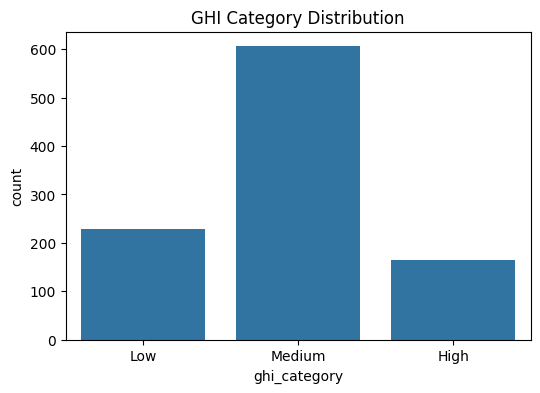

ghi_category
Medium    606
Low       229
High      165
Name: count, dtype: int64


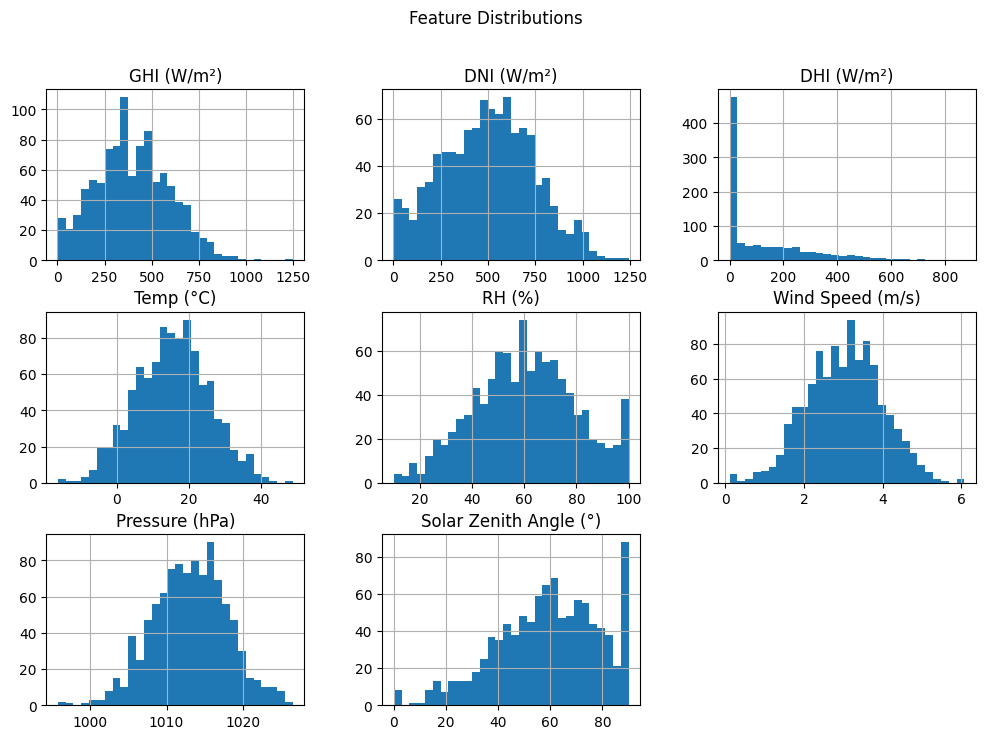

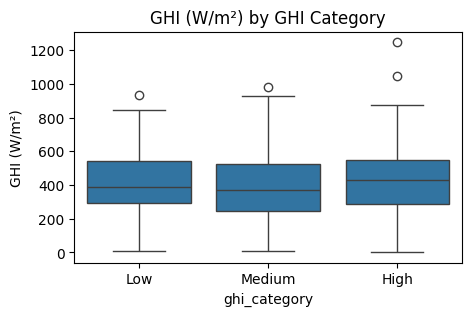

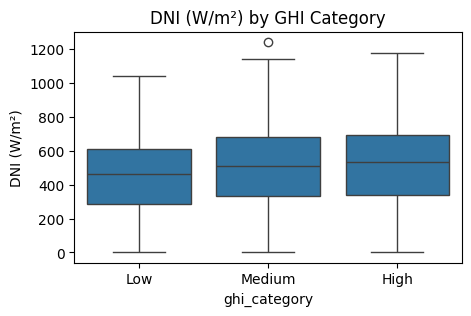

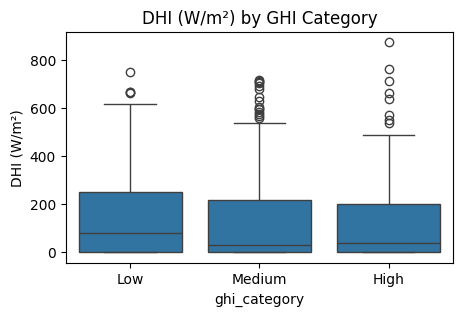

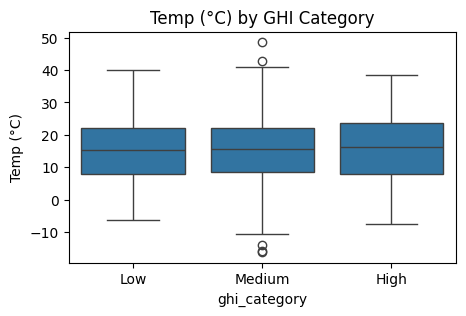

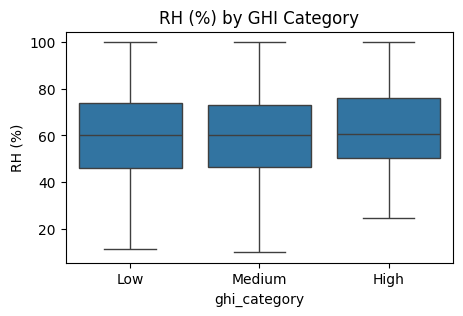

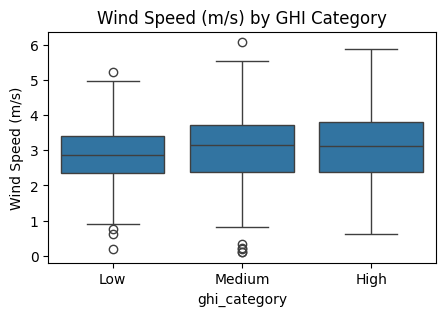

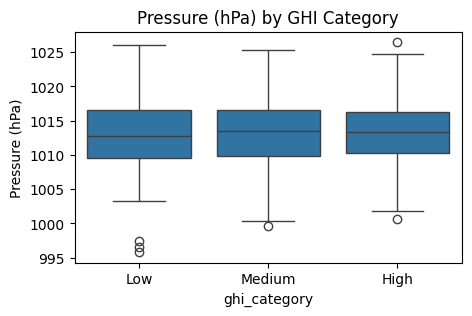

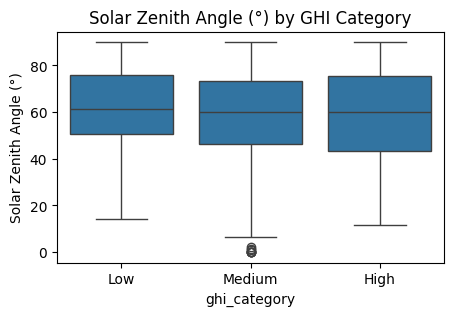

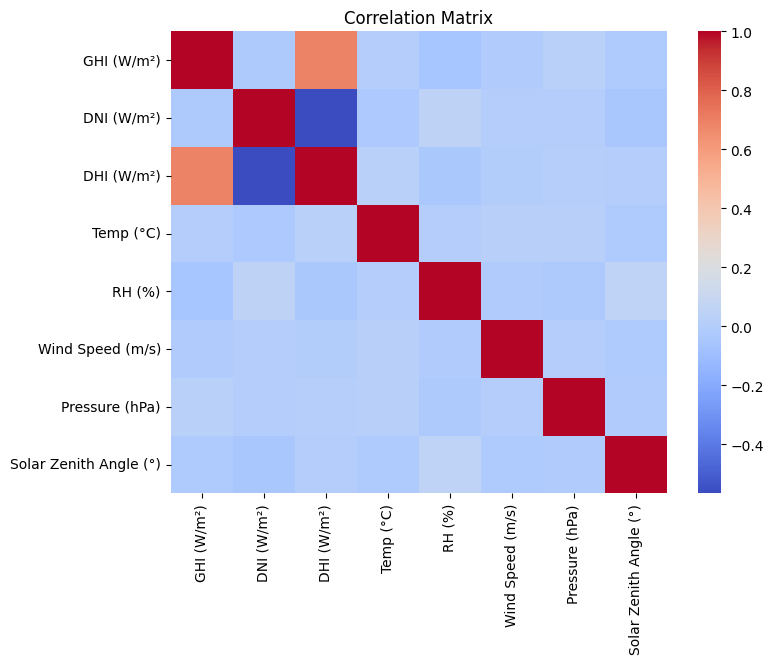

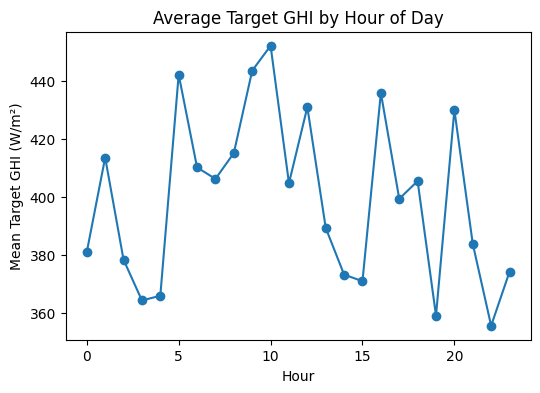

In [25]:
# Cell 5 – Detailed EDA

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Class balance
if 'ghi_category' in df_proc.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='ghi_category', data=df_proc, order=['Low','Medium','High'])
    plt.title('GHI Category Distribution')
    plt.show()
    print(df_proc['ghi_category'].value_counts())

# 2. Feature distributions
numeric_cols = [
    'GHI (W/m²)','DNI (W/m²)','DHI (W/m²)',
    'Temp (°C)','RH (%)','Wind Speed (m/s)',
    'Pressure (hPa)','Solar Zenith Angle (°)'
]
numeric_cols = [c for c in numeric_cols if c in df_proc.columns]

df_proc[numeric_cols].hist(bins=30, figsize=(12,8))
plt.suptitle('Feature Distributions')
plt.show()

# 3. Boxplots by category
if 'ghi_category' in df_proc.columns:
    for col in numeric_cols:
        plt.figure(figsize=(5,3))
        sns.boxplot(x='ghi_category', y=col, data=df_proc, order=['Low','Medium','High'])
        plt.title(f'{col} by GHI Category')
        plt.show()

# 4. Correlation heatmap
corr = df_proc[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

# 5. Time patterns
if 'Timestamp' in df_proc.columns and 'Target_GHI_NextHour (W/m²)' in df_proc.columns:
    df_proc['hour'] = pd.to_datetime(df_proc['Timestamp']).dt.hour
    hourly_avg = df_proc.groupby('hour')['Target_GHI_NextHour (W/m²)'].mean()
    plt.figure(figsize=(6,4))
    hourly_avg.plot(marker='o')
    plt.title('Average Target GHI by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Mean Target GHI (W/m²)')
    plt.show()


## Feature Engineering

In [ ]:
# Cell 6 – Feature Engineering (lags, rolling stats, cyclical time)

import numpy as np
import pandas as pd

# work on a copy so we keep df_proc intact
df_feat = df_proc.copy()

# 1) time features from Timestamp
df_feat['hour'] = pd.to_datetime(df_feat['Timestamp']).dt.hour
df_feat['dayofyear'] = pd.to_datetime(df_feat['Timestamp']).dt.dayofyear

# cyclical encodings (helps models learn daily/seasonal cycles)
df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 24)
df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 24)
df_feat['doy_sin']  = np.sin(2 * np.pi * df_feat['dayofyear'] / 365)
df_feat['doy_cos']  = np.cos(2 * np.pi * df_feat['dayofyear'] / 365)

# optional: simple daylight flag using solar zenith angle (<90 deg ~ sun above horizon)
if 'Solar Zenith Angle (°)' in df_feat.columns:
    df_feat['is_daylight'] = (df_feat['Solar Zenith Angle (°)'] < 90).astype(int)

# 2) choose base columns to lag/roll (only features available at time t)
base_cols = [
    'GHI (W/m²)','DNI (W/m²)','DHI (W/m²)',
    'Temp (°C)','RH (%)','Wind Speed (m/s)','Pressure (hPa)','Dew Point (°C)'
]
base_cols = [c for c in base_cols if c in df_feat.columns]  # guard if any missing

# 3) create lags: use the last 1 to 4 half-hour steps (up to 2 hours of history)
lags = [1, 2, 3, 4]
for col in base_cols:
    for L in lags:
        df_feat[f'{col}_lag{L}'] = df_feat[col].shift(L)

# 4) rolling window stats on past few steps (3 = 1.5h, 6 = 3h with 30 min cadence)
windows = [3, 6]
for col in base_cols:
    for w in windows:
        df_feat[f'{col}_roll{w}_mean'] = df_feat[col].rolling(w).mean()
        df_feat[f'{col}_roll{w}_std']  = df_feat[col].rolling(w).std()

# 5) drop rows made NaN by lags/rolling (front of the series)
before = df_feat.shape[0]
df_feat = df_feat.dropna().reset_index(drop=True)
after = df_feat.shape[0]
print(f'Dropped {before - after} rows due to lag/rolling windows. Remaining: {after}')

# 6) build a clean feature list for modeling
target_reg = 'Target_GHI_NextHour (W/m²)'
target_clf = 'ghi_category'

non_features = ['Timestamp', 'hour', 'dayofyear', target_reg, target_clf]  # keep raw time cols out of X
cloud_cols = [c for c in df_feat.columns if c.startswith('cloud_')]        # one-hot clouds already in df
lag_roll_cols = [c for c in df_feat.columns if ('_lag' in c) or ('_roll' in c)]

# base numeric at time t + engineered time signals + cloud dummies + lag/rolling
X_cols = []
X_cols += [c for c in base_cols if c in df_feat.columns]
X_cols += ['hour_sin','hour_cos','doy_sin','doy_cos']
if 'is_daylight' in df_feat.columns:
    X_cols += ['is_daylight']
X_cols += cloud_cols
X_cols += lag_roll_cols
X_cols = [c for c in X_cols if c not in non_features]  # safety filter

print(f'Number of features: {len(X_cols)}')

# quick peek
display(df_feat[X_cols + [target_reg, target_clf]].head(3))


Dropped 5 rows due to lag/rolling windows. Remaining: 995
Number of features: 82


,GHI (W/m²),DNI (W/m²),DHI (W/m²),Temp (°C),RH (%),Wind Speed (m/s),Pressure (hPa),Dew Point (°C),hour_sin,hour_cos,...,Pressure (hPa)_roll3_mean,Pressure (hPa)_roll3_std,Pressure (hPa)_roll6_mean,Pressure (hPa)_roll6_std,Dew Point (°C)_roll3_mean,Dew Point (°C)_roll3_std,Dew Point (°C)_roll6_mean,Dew Point (°C)_roll6_std,Target_GHI_NextHour (W/m²),ghi_category
0,341.691203,899.612847,0.000000,48.611715,54.400946,2.277953,1008.087079,47.188422,0.707107,0.707107,...,1012.313490,4.945202,1010.912952,3.530058,23.861790,20.234496,20.480833,13.865005,278.143286,Medium
1,509.841850,266.874470,321.133103,28.635296,39.140712,2.094676,1005.740468,26.076194,0.707107,0.707107,...,1010.526539,6.366542,1010.122652,4.126214,28.872981,17.089559,23.118480,13.008407,133.615893,Low
2,278.143286,77.320285,223.469588,27.901403,61.232812,3.454007,1022.391919,25.350014,0.866025,0.500000,...,1012.073155,9.013007,1012.295214,6.430490,32.871544,12.404096,24.138800,12.881705,400.212942,Medium


## Time-aware Chronological Split Data Spltting



In [ ]:
# Cell 7 – Chronological split + targets + scaling (train-only)

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Features (X) and targets (y) from Cell 6 outputs
X = df_feat[X_cols].copy()                                # model inputs
y_reg = df_feat['Target_GHI_NextHour (W/m²)'].copy()      # regression target
y_clf = df_feat['ghi_category'].astype(str).copy()        # classification target as strings

# 2) Optional: ensure all features are numeric (booleans → ints)
X = X.apply(pd.to_numeric, errors='coerce')               # safe cast; keeps NaNs if any appear (shouldn’t)
X = X.fillna(0)                                           # just in case; we dropped NaNs in Cell 6

# 3) Chronological split (no shuffling)
split_idx = int(0.8 * len(X))                             # 80% train, 20% test
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_reg_train, y_reg_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]
y_clf_train, y_clf_test = y_clf.iloc[:split_idx], y_clf.iloc[split_idx:]

print("Train size:", X_train.shape, "| Test size:", X_test.shape)

# 4) Scaling for models that benefit (linear, neural nets). Fit on TRAIN only to avoid leakage.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns, index=X_test.index
)

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)

# 5) Small sanity checks
print("y_reg train/test:", y_reg_train.shape, y_reg_test.shape)
print("y_clf classes (train):", sorted(y_clf_train.unique()))


Train size: (796, 82) | Test size: (199, 82)
Scaled shapes: (796, 82) (199, 82)
y_reg train/test: (796,) (199,)
y_clf classes (train): ['High', 'Low', 'Medium']


Classification Results
Accuracy: 0.593
Precision: 0.198 | Recall: 0.333 | F1: 0.248


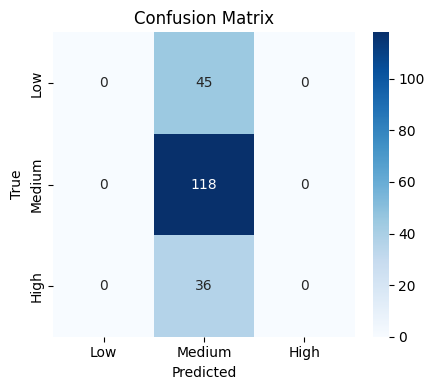


Regression Results
MAE:  164.60 W/m²
RMSE: 207.25 W/m²
R²:   -0.022


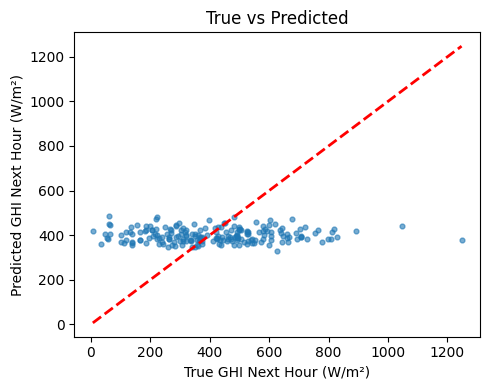

In [ ]:
# # Cell 8 – Baseline Models (Classification + Regression)

# import numpy as np                                  # basic numerical ops (used for sqrt)
# import pandas as pd                                 # standard data library (not strictly required here)
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # tree models
# from sklearn.metrics import (                        # evaluation metrics
#     accuracy_score, precision_recall_fscore_support, confusion_matrix,
#     mean_absolute_error, mean_squared_error, r2_score
# )
# import matplotlib.pyplot as plt                      # plotting
# import seaborn as sns                                # nicer plots for confusion matrix

# # Classification: predict Low / Medium / High
# clf = RandomForestClassifier(                        # create a random forest classifier
#     n_estimators=300,                                # number of trees (more -> more stable)
#     max_depth=None,                                  # let trees grow until they stop improving
#     random_state=42,                                 # reproducible results
#     n_jobs=-1                                        # use all CPU cores
# )
# clf.fit(X_train, y_clf_train)                        # train on the chronological training set
# y_clf_pred = clf.predict(X_test)                     # predict labels on the test period

# acc = accuracy_score(y_clf_test, y_clf_pred)         # overall classification accuracy
# prec, rec, f1, _ = precision_recall_fscore_support(  # macro-averaged precision/recall/F1 across classes
#     y_clf_test, y_clf_pred, average='macro', zero_division=0
# )

# print("Classification Results")
# print(f"Accuracy: {acc:.3f}")
# print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

# cm = confusion_matrix(                               # confusion matrix to see per-class hits/misses
#     y_clf_test, y_clf_pred, labels=['Low','Medium','High']
# )
# plt.figure(figsize=(4.5,4))                          # small, readable confusion matrix
# sns.heatmap(
#     cm, annot=True, fmt='d', cmap='Blues',
#     xticklabels=['Low','Medium','High'],
#     yticklabels=['Low','Medium','High']
# )
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.tight_layout()
# plt.show()

# # Regression: predict exact next-hour GHI (W/m²)
# reg = RandomForestRegressor(                         # create a random forest regressor
#     n_estimators=400,                                # a few more trees for smoother numeric predictions
#     max_depth=None,
#     random_state=42,
#     n_jobs=-1
# )
# reg.fit(X_train, y_reg_train)                        # train on the chronological training set
# y_reg_pred = reg.predict(X_test)                     # predict continuous values on the test period

# mae = mean_absolute_error(y_reg_test, y_reg_pred)    # average absolute error (easy to interpret)
# mse = mean_squared_error(y_reg_test, y_reg_pred)     # mean squared error
# rmse = np.sqrt(mse)                                  # root mean squared error (your sklearn lacks squared=False)
# r2 = r2_score(y_reg_test, y_reg_pred)                # variance explained (1.0 is perfect)

# print("\nRegression Results")
# print(f"MAE:  {mae:.2f} W/m²")
# print(f"RMSE: {rmse:.2f} W/m²")
# print(f"R²:   {r2:.3f}")

# plt.figure(figsize=(5,4))                            # true vs predicted scatter for a quick visual check
# plt.scatter(y_reg_test, y_reg_pred, s=12, alpha=0.6)
# mn, mx = y_reg_test.min(), y_reg_test.max()          # diagonal reference line limits
# plt.plot([mn, mx], [mn, mx], 'r--', lw=2)           # ideal line (perfect predictions)
# plt.xlabel('True GHI Next Hour (W/m²)')
# plt.ylabel('Predicted GHI Next Hour (W/m²)')
# plt.title('True vs Predicted')
# plt.tight_layout()
# plt.show()


[Classification] Using top 50 features; class counts: {'Medium': 254, 'High': 248, 'Low': 244}
Best RF-Classifier params: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 8, 'bootstrap': True} (search 200.2s)

[Classification] Random Forest – Test
Accuracy: 0.360 | Precision: 0.348 | Recall: 0.351 | F1: 0.348
Train time: search=200.2s, final_fit=12.2s


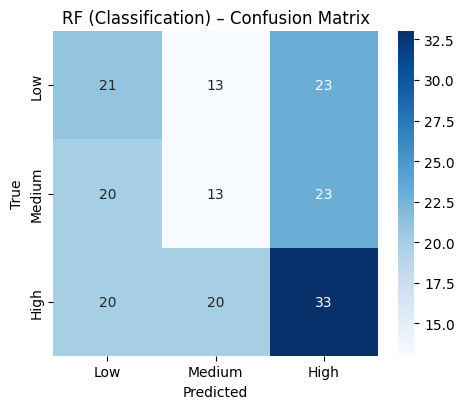

[Regression] Using top 60 features
Best RF-Regressor params: {'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 12, 'bootstrap': True} (search 197.4s)

[Regression] Random Forest – Test
MAE: 164.02 W/m² | RMSE: 205.19 W/m² | R²: -0.002
Train time: search=197.4s, final_fit=4.8s


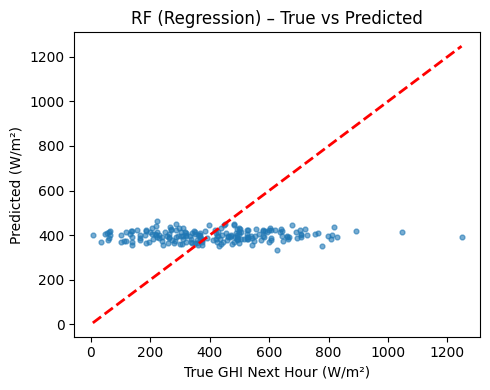

In [21]:
# Cell 9 – Random Forest (Classification + Regression) • Regularized + Tuned

import numpy as np
import pandas as pd
import time
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, mean_absolute_error, mean_squared_error, r2_score)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 0) Config ----------
DAYLIGHT_ONLY = True         # set False to use all rows for classification
TOPK_CLF = 50                # features kept for classification
TOPK_REG = 60                # features kept for regression
CV_SPLITS = 3                # TimeSeriesSplit folds (kept small for speed)
N_ITER_CLF = 24              # randomized search iterations (classification)
N_ITER_REG = 24              # randomized search iterations (regression)

# Requires: X_train, X_test, y_reg_train, y_reg_test, df_feat (from your previous cells)

# ---------- 1) Build balanced 3-class labels from TRAIN tertiles (no leakage) ----------
q1, q2 = y_reg_train.quantile([1/3, 2/3]).values
def to_tertile(v):
    if v <= q1: return "Low"
    elif v <= q2: return "Medium"
    else: return "High"

y_clf_train = y_reg_train.apply(to_tertile)
y_clf_test  = y_reg_test.apply(to_tertile)

# ---------- 2) Classification data: optional daylight filter (avoids night noise) ----------
if DAYLIGHT_ONLY and ('is_daylight' in df_feat.columns):
    train_idx = X_train.index[df_feat.loc[X_train.index, 'is_daylight'] == 1]
    test_idx  = X_test.index[df_feat.loc[X_test.index,  'is_daylight'] == 1]
else:
    train_idx, test_idx = X_train.index, X_test.index

Xc_train_raw = X_train.loc[train_idx].copy()
yc_train     = y_clf_train.loc[train_idx].copy()
Xc_test_raw  = X_test.loc[test_idx].copy()
yc_test      = y_clf_test.loc[test_idx].copy()

# ---------- 3) Handle imbalance with inverse-frequency sample weights ----------
cls_counts = yc_train.value_counts()
inv_freq = {c: 1.0 / cls_counts[c] for c in cls_counts.index}
sample_weight_clf = yc_train.map(inv_freq).values

# ---------- 4) Quick feature selection with a small RF (reduces noise before tuning) ----------
rf_fs = RandomForestClassifier(
    n_estimators=300, random_state=42, n_jobs=-1, class_weight='balanced_subsample'
)
rf_fs.fit(Xc_train_raw, yc_train, sample_weight=sample_weight_clf)
imp_clf = pd.Series(rf_fs.feature_importances_, index=Xc_train_raw.columns).sort_values(ascending=False)
clf_cols = imp_clf.head(TOPK_CLF).index.tolist()

Xc_train = Xc_train_raw[clf_cols]
Xc_test  = Xc_test_raw[clf_cols]

print(f"[Classification] Using top {len(clf_cols)} features; class counts:", cls_counts.to_dict())

# ---------- 5) Random Forest CLASSIFIER: randomized search (regularized) ----------
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample')
param_dist_clf = {
    'n_estimators':      [300, 500, 800],       # modest during search
    'max_depth':         [6, 8, 10, 12],        # shallower trees reduce variance
    'min_samples_split': [10, 20, 40],          # larger splits -> smoother trees
    'min_samples_leaf':  [5, 10, 20],           # larger leaves -> smoother trees
    'max_features':      ['sqrt', 0.3, 0.5],    # randomness for generalization
    'bootstrap':         [True]
}
tscv = TimeSeriesSplit(n_splits=CV_SPLITS)

search_clf = RandomizedSearchCV(
    rf_clf, param_distributions=param_dist_clf, n_iter=N_ITER_CLF,
    cv=tscv, scoring='accuracy', n_jobs=-1, random_state=42, verbose=0
)
t0 = time.time()
search_clf.fit(Xc_train, yc_train, sample_weight=sample_weight_clf)
t_clf_search = time.time() - t0

best_clf = search_clf.best_estimator_
print("Best RF-Classifier params:", search_clf.best_params_, f"(search {t_clf_search:.1f}s)")

# Refit with more trees for stability (same regularization)
best_clf.set_params(n_estimators=1000)
t1 = time.time()
best_clf.fit(Xc_train, yc_train, sample_weight=sample_weight_clf)
t_clf_fit = time.time() - t1

# ---------- 6) Evaluate CLASSIFICATION ----------
y_pred_clf = best_clf.predict(Xc_test)
acc = accuracy_score(yc_test, y_pred_clf)
prec, rec, f1, _ = precision_recall_fscore_support(yc_test, y_pred_clf, average='macro', zero_division=0)

print("\n[Classification] Random Forest – Test")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print(f"Train time: search={t_clf_search:.1f}s, final_fit={t_clf_fit:.1f}s")

cm = confusion_matrix(yc_test, y_pred_clf, labels=['Low','Medium','High'])
plt.figure(figsize=(4.8,4.2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
plt.title('RF (Classification) – Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

# ---------- 7) Regression data: (use all rows; separate feature selection) ----------
rf_fs_r = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf_fs_r.fit(X_train, y_reg_train)
imp_reg = pd.Series(rf_fs_r.feature_importances_, index=X_train.columns).sort_values(ascending=False)
reg_cols = imp_reg.head(TOPK_REG).index.tolist()

Xr_train = X_train[reg_cols]
Xr_test  = X_test[reg_cols]
print(f"[Regression] Using top {len(reg_cols)} features")

# ---------- 8) Random Forest REGRESSOR: randomized search (regularized) ----------
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)
param_dist_reg = {
    'n_estimators':      [400, 700, 1000],
    'max_depth':         [8, 12, 16, None],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf':  [5, 10, 20],
    'max_features':      ['sqrt', 0.3, 0.5],
    'bootstrap':         [True]
}

search_reg = RandomizedSearchCV(
    rf_reg, param_distributions=param_dist_reg, n_iter=N_ITER_REG,
    cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42, verbose=0
)
t2 = time.time()
search_reg.fit(Xr_train, y_reg_train)
t_reg_search = time.time() - t2

best_reg = search_reg.best_estimator_
print("Best RF-Regressor params:", search_reg.best_params_, f"(search {t_reg_search:.1f}s)")

# Refit with more trees for stability
best_reg.set_params(n_estimators=1200)
t3 = time.time()
best_reg.fit(Xr_train, y_reg_train)
t_reg_fit = time.time() - t3

# ---------- 9) Evaluate REGRESSION ----------
y_pred_reg = best_reg.predict(Xr_test)
mae = mean_absolute_error(y_reg_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
r2 = r2_score(y_reg_test, y_pred_reg)

print("\n[Regression] Random Forest – Test")
print(f"MAE: {mae:.2f} W/m² | RMSE: {rmse:.2f} W/m² | R²: {r2:.3f}")
print(f"Train time: search={t_reg_search:.1f}s, final_fit={t_reg_fit:.1f}s")

plt.figure(figsize=(5,4))
plt.scatter(y_reg_test, y_pred_reg, s=12, alpha=0.6)
mn, mx = y_reg_test.min(), y_reg_test.max()
plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
plt.xlabel('True GHI Next Hour (W/m²)'); plt.ylabel('Predicted (W/m²)')
plt.title('RF (Regression) – True vs Predicted'); plt.tight_layout(); plt.show()


## Random Forest Classifier (Full Build – From Scratch)

[I 2025-08-08 23:18:41,836] A new study created in memory with name: no-name-21b7ce26-5433-4333-acc5-291a7f27b214


Running Optuna hyperparameter search for Random Forest…


[I 2025-08-08 23:18:50,588] Trial 0 finished with value: 0.41195244861245933 and parameters: {'bootstrap': False, 'n_estimators': 932, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.41195244861245933.
[I 2025-08-08 23:19:00,387] Trial 1 finished with value: 0.4103202050944768 and parameters: {'bootstrap': True, 'max_samples': 0.9879639408647978, 'n_estimators': 1033, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.41195244861245933.
[I 2025-08-08 23:19:03,457] Trial 2 finished with value: 0.41935038202057345 and parameters: {'bootstrap': False, 'n_estimators': 339, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.41935038202057345.
[I 2025-08-08 23:19:07,309] Trial 3 finished with value: 0.4161542621191816 and parameters: {'bootstrap': True, 'max_samples': 0.8430179407605753, 'n

Best params: {'bootstrap': False, 'n_estimators': 830, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}
Best CV weighted F1: 0.4345

RF Test Accuracy: 0.4100
RF Test F1 (weighted): 0.3876

Classification Report:
              precision    recall  f1-score   support

        High       0.11      0.06      0.07        36
         Low       0.31      0.29      0.30        62
      Medium       0.51      0.61      0.55       102

    accuracy                           0.41       200
   macro avg       0.31      0.32      0.31       200
weighted avg       0.37      0.41      0.39       200



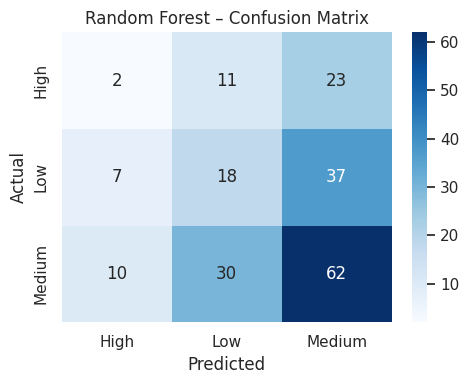

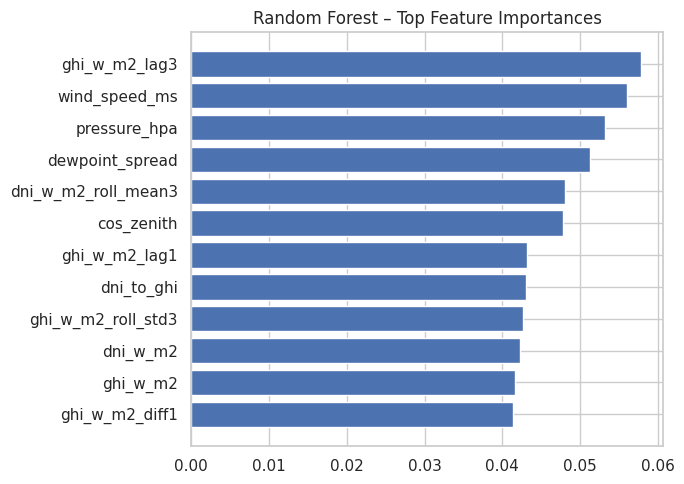

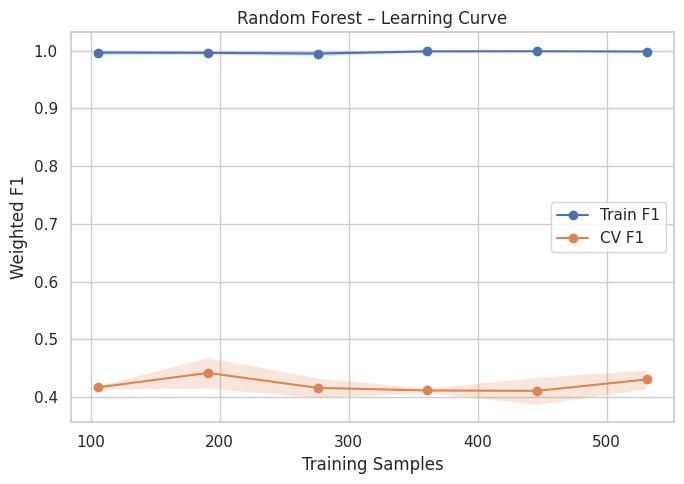

In [ ]:
# # Cell 7 – Random Forest Classifier (with Optuna tuning + TS-aware CV)

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# import optuna
# from optuna.samplers import TPESampler

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import TimeSeriesSplit, learning_curve
# from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# # --- Guards ---
# need = ['X_train_tree','X_test_tree','y_train','y_test','label_encoder','feature_names']
# miss = [v for v in need if v not in globals()]
# if miss:
#     raise NameError(f"Missing variables: {miss}. Run Cells 3–6 first.")

# # Arrays for CV speed
# Xtr_df, Xte_df = X_train_tree, X_test_tree
# Xtr = Xtr_df.values
# Xte = Xte_df.values
# ytr = np.asarray(y_train)
# yte = np.asarray(y_test)
# feat_names = feature_names
# class_names = list(label_encoder.classes_)

# # --- Optuna objective (TimeSeriesSplit) ---
# def objective(trial):
#     bootstrap = trial.suggest_categorical('bootstrap', [True, False])
#     max_samples = trial.suggest_float('max_samples', 0.6, 1.0) if bootstrap else None

#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
#         'max_depth': trial.suggest_int('max_depth', 5, 20),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt','log2', 0.5]),
#         'bootstrap': bootstrap,
#         'max_samples': max_samples,
#         'class_weight': 'balanced',
#         'random_state': 42,
#         'n_jobs': -1
#     }

#     tscv = TimeSeriesSplit(n_splits=3)
#     scores = []
#     for tr_idx, vl_idx in tscv.split(Xtr):
#         clf = RandomForestClassifier(**params)
#         clf.fit(Xtr[tr_idx], ytr[tr_idx])
#         pred = clf.predict(Xtr[vl_idx])
#         scores.append(f1_score(ytr[vl_idx], pred, average='weighted'))
#     return float(np.mean(scores))

# print("Running Optuna hyperparameter search for Random Forest…")
# study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
# study.optimize(objective, n_trials=30)

# best_params = study.best_params
# best_params.update({'class_weight':'balanced','random_state':42,'n_jobs':-1})
# print("Best params:", best_params)
# print(f"Best CV weighted F1: {study.best_value:.4f}")

# # --- Train final model ---
# rf = RandomForestClassifier(**best_params)
# rf.fit(Xtr, ytr)

# # --- Evaluate on test set ---
# yp = rf.predict(Xte)
# acc = accuracy_score(yte, yp)
# f1w = f1_score(yte, yp, average='weighted')
# print(f"\nRF Test Accuracy: {acc:.4f}")
# print(f"RF Test F1 (weighted): {f1w:.4f}")
# print("\nClassification Report:")
# print(classification_report(yte, yp, target_names=class_names))

# # --- Confusion matrix ---
# cm = confusion_matrix(yte, yp)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names, yticklabels=class_names)
# plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Random Forest – Confusion Matrix")
# plt.tight_layout(); plt.show()

# # --- Top feature importances ---
# importances = rf.feature_importances_
# idx = np.argsort(importances)[-12:]  # top 12
# plt.figure(figsize=(7,5))
# plt.barh(range(len(idx)), importances[idx])
# plt.yticks(range(len(idx)), [feat_names[i] for i in idx])
# plt.title("Random Forest – Top Feature Importances")
# plt.tight_layout(); plt.show()

# # --- Learning curve (weighted F1) on training set ---
# sizes, tr_scores, vl_scores = learning_curve(
#     rf, Xtr, ytr, cv=3, scoring='f1_weighted', n_jobs=-1,
#     train_sizes=np.linspace(0.2, 1.0, 6), shuffle=False
# )
# tr_mean, tr_std = tr_scores.mean(axis=1), tr_scores.std(axis=1)
# vl_mean, vl_std = vl_scores.mean(axis=1), vl_scores.std(axis=1)

# plt.figure(figsize=(7,5))
# plt.plot(sizes, tr_mean, 'o-', label="Train F1")
# plt.fill_between(sizes, tr_mean-tr_std, tr_mean+tr_std, alpha=0.2)
# plt.plot(sizes, vl_mean, 'o-', label="CV F1")
# plt.fill_between(sizes, vl_mean-vl_std, vl_mean+vl_std, alpha=0.2)
# plt.xlabel("Training Samples"); plt.ylabel("Weighted F1")
# plt.title("Random Forest – Learning Curve")
# plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## XGBoost Classifier – Chronological Split & Evaluation

In [ ]:
# ============================================================
# Cell 8: XGBoost (time-series CV, class weights, Booster API,
#          robust early stopping, best-iteration predict)
# Goal: fix ES TypeError, widen search, and push accuracy/F1 up
# ============================================================

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

import xgboost as xgb
from xgboost import __version__ as xgb_ver
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("XGBoost version:", xgb_ver)

# ------------------------------------------------------------------
# 0) Inputs from previous cells
# ------------------------------------------------------------------
le = label_encoder  # from your preprocessing cell

# Drop raw hour/month if present (we use cyclical encodings instead)
to_prune = [c for c in ['hour', 'month'] if c in X_train.columns]
X_tr = X_train.drop(columns=to_prune) if to_prune else X_train.copy()
X_te = X_test.drop(columns=to_prune)   if to_prune else X_test.copy()

y_tr_full = y_train.copy()
y_te_full = y_test.copy()

# Class weights for imbalance (encoded class ids 0..K-1)
classes = np.unique(y_tr_full)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr_full)
CLASS_WEIGHT_MAP = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class weights:", {le.inverse_transform([c])[0]: round(w, 2) for c, w in CLASS_WEIGHT_MAP.items()})

NUM_CLASS = len(le.classes_)
USE_CLASS_WEIGHTS = True  # flip to False to A/B test without weights

# ------------------------------------------------------------------
# 1) Helpers: DMatrix builder, safe training, and prediction
# ------------------------------------------------------------------
def _weights_for(y):
    if not USE_CLASS_WEIGHTS:
        return np.ones_like(y, dtype=np.float32)
    return np.array([CLASS_WEIGHT_MAP[int(c)] for c in y], dtype=np.float32)

def make_dmatrix(X, y=None, w=None):
    if y is None:
        return xgb.DMatrix(X)
    if w is None:
        w = _weights_for(y)
    return xgb.DMatrix(X, label=y, weight=w)

def train_booster(params, dtrain, dval, num_boost_round=5000, early_stopping_rounds=100):
    """Train with ES; try GPU first, fall back to CPU."""
    params = params.copy()
    # Prefer GPU if available; if it errors, fall back to CPU hist.
    tried_gpu = False
    try:
        params_gpu = params.copy()
        # XGBoost >=1.6: 'tree_method': 'gpu_hist' works broadly
        params_gpu.setdefault('tree_method', 'gpu_hist')
        booster = xgb.train(
            params_gpu, dtrain,
            num_boost_round=num_boost_round,
            evals=[(dtrain, 'train'), (dval, 'val')],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
        tried_gpu = True
        return booster, 'gpu_hist'
    except Exception:
        pass

    # CPU fallback
    params.setdefault('tree_method', 'hist')
    booster = xgb.train(
        params, dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False
    )
    return booster, ('hist' if not tried_gpu else 'gpu->cpu')

def predict_labels(booster, dmat):
    """Robust 'use-best-iteration' prediction for multi:softprob."""
    # Try modern API (iteration_range), else fall back to ntree_limit, else default.
    try:
        probs = booster.predict(dmat, iteration_range=(0, booster.best_iteration + 1))
    except Exception:
        try:
            probs = booster.predict(dmat, ntree_limit=getattr(booster, 'best_ntree_limit', 0) or None)
        except Exception:
            probs = booster.predict(dmat)
    if probs.ndim == 1:  # just in case
        return probs.astype(int)
    return np.argmax(probs, axis=1)

# ------------------------------------------------------------------
# 2) Optuna objective with TimeSeriesSplit (weighted-F1)
# ------------------------------------------------------------------
def xgb_objective(trial):
    params = {
        # Capacity + regularization (wider, but sane)
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth'        : trial.suggest_int('max_depth', 4, 12),
        'max_leaves'       : trial.suggest_int('max_leaves', 31, 255),
        'grow_policy'      : 'lossguide',
        'min_child_weight' : trial.suggest_float('min_child_weight', 1.0, 20.0),
        'gamma'            : trial.suggest_float('gamma', 0.0, 5.0),
        'subsample'        : trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1.0, 50.0),

        # Multi-class setup
        'objective'        : 'multi:softprob',
        'num_class'        : NUM_CLASS,
        'eval_metric'      : ['mlogloss', 'merror'],
        'verbosity'        : 0,
        # tree_method decided inside train_booster (GPU -> CPU fallback)
    }

    tscv = TimeSeriesSplit(n_splits=3)
    fold_scores = []

    for tr_idx, val_idx in tscv.split(X_tr):
        X_tr_fold, y_tr_fold = X_tr.iloc[tr_idx], y_tr_full[tr_idx]
        X_val_fold, y_val_fold = X_tr.iloc[val_idx], y_tr_full[val_idx]

        dtr  = make_dmatrix(X_tr_fold, y_tr_fold)
        dval = make_dmatrix(X_val_fold, y_val_fold)

        booster, tm = train_booster(params, dtr, dval, num_boost_round=4000, early_stopping_rounds=100)
        y_hat = predict_labels(booster, dval)

        fold_scores.append(f1_score(y_val_fold, y_hat, average='weighted'))

    return float(np.mean(fold_scores))

print("Running Optuna hyperparameter search for XGBoost...")
sampler = TPESampler(seed=42)
pruner  = MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
# Increase n_trials if you have time/GPU; 60 is a good start
study.optimize(xgb_objective, n_trials=60, timeout=None, show_progress_bar=True)

best_params = study.best_params
best_params.update({
    'objective'   : 'multi:softprob',
    'num_class'   : NUM_CLASS,
    'eval_metric' : ['mlogloss', 'merror'],
    'verbosity'   : 0
})
print("Best params:", best_params)
print("Best CV weighted F1:", f"{study.best_value:.4f}")

# ------------------------------------------------------------------
# 3) Final model: keep a small validation tail from TRAIN to get best_round,
#    then refit on FULL TRAIN (train+val) using that best_round
# ------------------------------------------------------------------
val_cut = int(len(X_tr) * 0.9)
X_fit, y_fit = X_tr.iloc[:val_cut], y_tr_full[:val_cut]
X_val, y_val = X_tr.iloc[val_cut:],  y_tr_full[val_cut:]

dfit = make_dmatrix(X_fit, y_fit)
dval = make_dmatrix(X_val, y_val)

t0 = time.time()
booster_val, tm_used = train_booster(best_params, dfit, dval, num_boost_round=6000, early_stopping_rounds=150)
best_round = getattr(booster_val, 'best_iteration', None)
if best_round is None:
    # older API
    best_round = getattr(booster_val, 'best_ntree_limit', None)
    if isinstance(best_round, int) and best_round > 0:
        best_round = best_round - 1  # ntree_limit is #trees, iteration is 0-based
    else:
        best_round = 1000  # fallback
print(f"Validation-tuned best_round: {best_round} (tree_method: {tm_used})")
print(f"Val-tuning time: {time.time()-t0:.2f}s")

# Refit on full TRAIN (X_tr) using best_round (no early stopping)
dfull = make_dmatrix(X_tr, y_tr_full)
t1 = time.time()
booster_final = xgb.train(
    {**best_params, 'tree_method': 'gpu_hist'},  # will fallback below if GPU not available
    dfull,
    num_boost_round=int(best_round + 1),
    verbose_eval=False
)
used_method = 'gpu_hist'
# Fallback to CPU if GPU param errors
try:
    _ = booster_final.attributes()
except Exception:
    booster_final = xgb.train(
        {**best_params, 'tree_method': 'hist'},
        dfull,
        num_boost_round=int(best_round + 1),
        verbose_eval=False
    )
    used_method = 'hist'
print(f"Full-train refit time: {time.time()-t1:.2f}s (tree_method: {used_method})")

# ------------------------------------------------------------------
# 4) Evaluate on HOLDOUT TEST
# ------------------------------------------------------------------
dtest = xgb.DMatrix(X_te)
y_pred_id = predict_labels(booster_final, dtest)

acc = accuracy_score(y_te_full, y_pred_id)
f1w = f1_score(y_te_full, y_pred_id, average='weighted')
print(f"\nXGB Accuracy: {acc:.4f}")
print(f"XGB Weighted F1: {f1w:.4f}")
print("Classification Report:")
print(classification_report(y_te_full, y_pred_id, target_names=le.classes_))

cm = confusion_matrix(y_te_full, y_pred_id)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.tight_layout()
plt.show()


[I 2025-08-09 00:37:48,992] A new study created in memory with name: no-name-ebc6f4e2-1fd4-4e55-ab83-66e44fb0244f


XGBoost version: 3.0.3
Class weights: {'High': 2.08, 'Low': 1.03, 'Medium': 0.65}
Running Optuna hyperparameter search for XGBoost...


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-08-09 00:37:49,882] Trial 0 finished with value: 0.3976392353692269 and parameters: {'learning_rate': 0.023688639503640783, 'max_depth': 12, 'max_leaves': 195, 'min_child_weight': 12.374511199743695, 'gamma': 0.7800932022121826, 'subsample': 0.662397808134481, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 30.45463557541723}. Best is trial 0 with value: 0.3976392353692269.
[I 2025-08-09 00:37:53,686] Trial 1 finished with value: 0.39172054031118125 and parameters: {'learning_rate': 0.051059032093947576, 'max_depth': 4, 'max_leaves': 249, 'min_child_weight': 16.816410175208013, 'gamma': 1.0616955533913808, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 26.713065149979656}. Best is trial 0 with value: 0.3976392353692269.
[I 2025-08-09 00:37:55,189] Trial 2 finished with value: 0.42347129688274654 and parameters: {'learning_rate': 0.027036160666620016, 'max_depth': 6

XGBoostError: [00:39:48] /workspace/src/tree/updater_gpu_hist.cu:847: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x2a6e7c) [0x7c18c9aa6e7c]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xfd7794) [0x7c18ca7d7794]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xfdf4e6) [0x7c18ca7df4e6]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x63b5b2) [0x7c18c9e3b5b2]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x63c657) [0x7c18c9e3c657]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x68d33e) [0x7c18c9e8d33e]
  [bt] (6) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x77) [0x7c18c99b6f57]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7c1922711e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7c192270e493]



Sliding-window shapes:
  X_train_win: (790, 8, 28)  y_train_win: (790,)
  X_test_win : (193, 8, 28)   y_test_win : (193,)
Class weights (windowed train): {'High': 2.06, 'Low': 1.03, 'Medium': 0.65}


Model: "cnn_ghi_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8, 28)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 8, 64)          │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 64)          │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,107 (121.51 KB)

 Trainable params: 30,723 (120.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.2555 - loss: 2.0856 - val_accuracy: 0.3861 - val_loss: 1.7046 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3314 - loss: 1.8513 - val_accuracy: 0.4620 - val_loss: 1.6641 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4012 - loss: 1.7655 - val_accuracy: 0.4873 - val_loss: 1.6387 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3886 - loss: 1.7220 - val_accuracy: 0.4304 - val_loss: 1.6185 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4342 - loss: 1.6435 - val_accuracy: 0.3987 - val_loss: 1.5974 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4313 - loss: 1.6049 - val_accuracy: 0.3734 - val_loss: 1.5977 - learning_rate: 0.0010
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4629 - loss: 1.5307 -

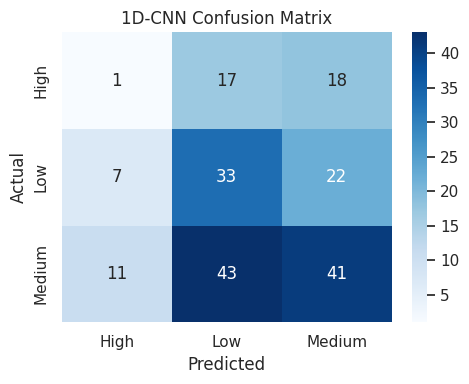

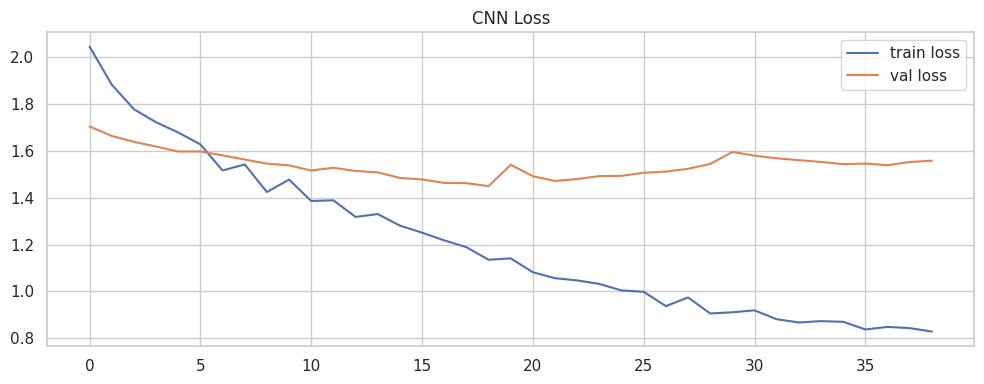

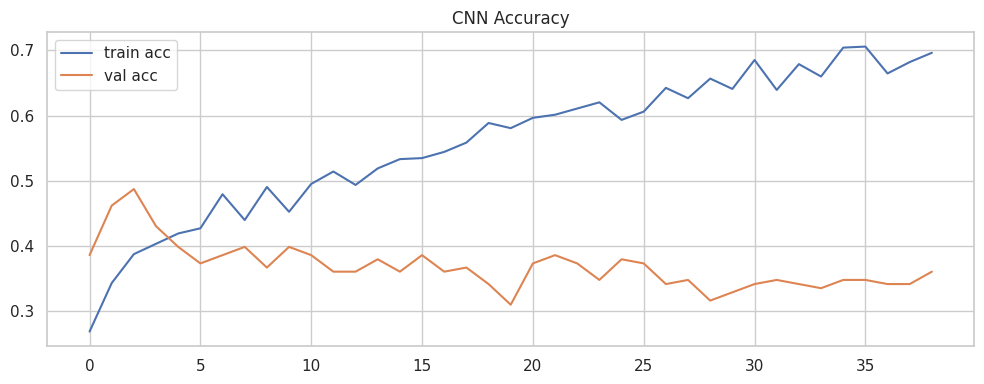

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, callbacks, optimizers

# --- 0) Safety checks / inputs expected from previous cells ---
# Expected: X_train, X_test (DataFrames), y_train, y_test (np arrays/Series), le (LabelEncoder)
for v in ["X_train", "X_test", "y_train", "y_test", "le"]:
    if v not in globals():
        raise NameError(f"Missing {v}. Run Cells 5–6 first.")

# --- 1) Sliding-window builder (no leakage; label = last step in the window) ---
def make_windows(X_df, y_arr, steps: int):
    X_arr = np.asarray(X_df, dtype=np.float32)
    y_arr = np.asarray(y_arr)
    n = len(X_arr)
    if n < steps:
        raise ValueError(f"Not enough rows ({n}) for steps={steps}")
    X_win = np.stack([X_arr[i:i+steps, :] for i in range(n - steps + 1)])
    y_win = y_arr[steps - 1 : n]  # align to last row in each window
    return X_win, y_win

# --- 2) Choose window length; try {6, 8, 12} in small sweeps ---
WIN_STEPS = 8  # try 8 first; then compare 6 and 12

# Derive features/step so we can reshape correctly
n_feats = X_train.shape[1]

# Build windowed train/test
X_train_win, y_train_win = make_windows(X_train, y_train, steps=WIN_STEPS)
X_test_win,  y_test_win  = make_windows(X_test,  y_test,  steps=WIN_STEPS)

# Reshape to [samples, steps, features] for Conv1D
X_train_win = X_train_win.reshape((-1, WIN_STEPS, n_feats))
X_test_win  = X_test_win.reshape((-1, WIN_STEPS, n_feats))

print("Sliding-window shapes:")
print(f"  X_train_win: {X_train_win.shape}  y_train_win: {y_train_win.shape}")
print(f"  X_test_win : {X_test_win.shape}   y_test_win : {y_test_win.shape}")

# --- 3) Class weights to combat imbalance (High is the minority) ---
classes = np.unique(y_train_win)
cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_win)
class_weight = {int(c): float(w) for c, w in zip(classes, cw_vals)}
print("Class weights (windowed train):", {le.inverse_transform([c])[0]: round(class_weight[int(c)], 2) for c in classes})

# --- 4) 1D-CNN model (compact, regularized) ---
def build_cnn(steps, feats, n_classes=3):
    inp = layers.Input(shape=(steps, feats))
    x = layers.Conv1D(64, kernel_size=3, padding="causal")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv1D(64, kernel_size=5, padding="causal", dilation_rate=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    # Global pooling captures order while keeping params small
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(64, kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(n_classes, activation="softmax")(x)
    model = models.Model(inp, out, name="cnn_ghi_classifier")
    return model

cnn = build_cnn(WIN_STEPS, n_feats, n_classes=len(le.classes_))
cnn.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
cnn.summary()

# --- 5) Callbacks: early stop + LR schedule; keep chronological validation split ---
cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5)
]

history = cnn.fit(
    X_train_win, y_train_win,
    epochs=200,
    batch_size=32,
    validation_split=0.2,     # last 20% of training windows
    shuffle=False,            # IMPORTANT for time-series
    class_weight=class_weight,
    callbacks=cbs,
    verbose=1
)

# --- 6) Evaluate on test windows ---
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
y_pred_prob = cnn.predict(X_test_win, verbose=0)
y_pred_win  = y_pred_prob.argmax(axis=1)

acc  = accuracy_score(y_test_win, y_pred_win)
f1w  = f1_score(y_test_win, y_pred_win, average="weighted")
print(f"\nCNN Test Accuracy: {acc:.4f}")
print(f"CNN Test Weighted F1: {f1w:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_win, y_pred_win, target_names=le.classes_))

# --- 7) Confusion matrix ---
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test_win, y_pred_win)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("1D-CNN Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# --- 8) Training curves ---
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.title("CNN Loss"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend(); plt.title("CNN Accuracy"); plt.tight_layout(); plt.show()


✅ TensorFlow version: 2.18.0


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_148 (Dense)               │ (None, 512)            │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,579 (971.01 KB)

 Trainable params: 246,787 (964.01 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
25/25 - 6s - 239ms/step - accuracy: 0.3308 - loss: 1.7459 - val_accuracy: 0.2663 - val_loss: 1.1784 - learning_rate: 1.0000e-04
Epoch 2/50
25/25 - 0s - 12ms/step - accuracy: 0.3346 - loss: 1.6012 - val_accuracy: 0.2814 - val_loss: 1.2062 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
25/25 - 1s - 25ms/step - accuracy: 0.3662 - loss: 1.5553 - val_accuracy: 0.2513 - val_loss: 1.2392 - learning_rate: 1.0000e-04
Epoch 4/50
25/25 - 0s - 12ms/step - accuracy: 0.3561 - loss: 1.5087 - val_accuracy: 0.2412 - val_loss: 1.2778 - learning_rate: 5.0000e-05
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
25/25 - 0s - 12ms/step - accuracy: 0.4141 - loss: 1.4091 - val_accuracy: 0.2312 - val_loss: 1.3016 - learning_rate: 5.0000e-05
Epoch 6/50
25/25 - 1s - 25ms/step - accuracy: 0.3712 - loss: 1.4299 - val_accuracy: 0.2412 - val_loss: 1.3181 - learning_rate: 2.5000e-05
Epoch 6: early st

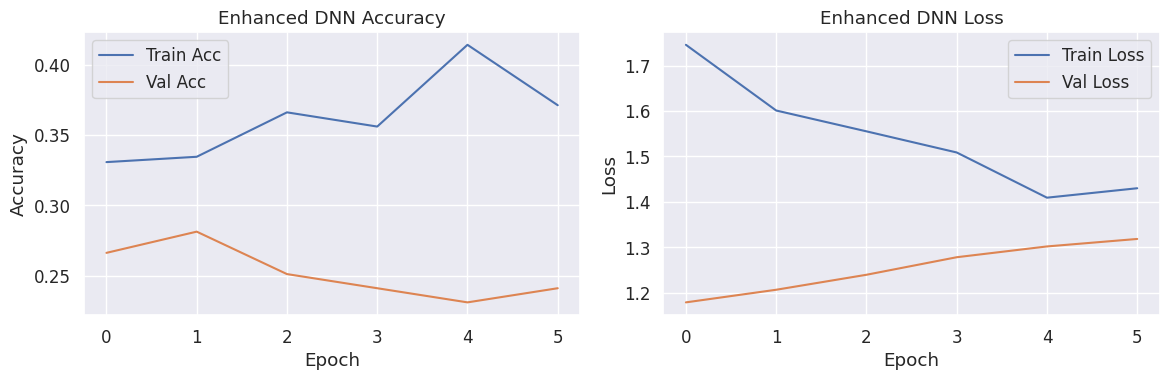

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Classification Report:
              precision    recall  f1-score   support

        High       0.20      0.28      0.23        36
         Low       0.25      0.45      0.32        62
      Medium       0.42      0.15      0.22       101

    accuracy                           0.27       199
   macro avg       0.29      0.29      0.26       199
weighted avg       0.32      0.27      0.25       199



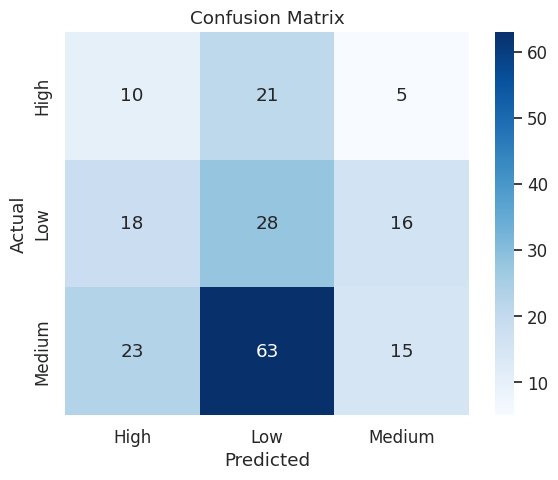

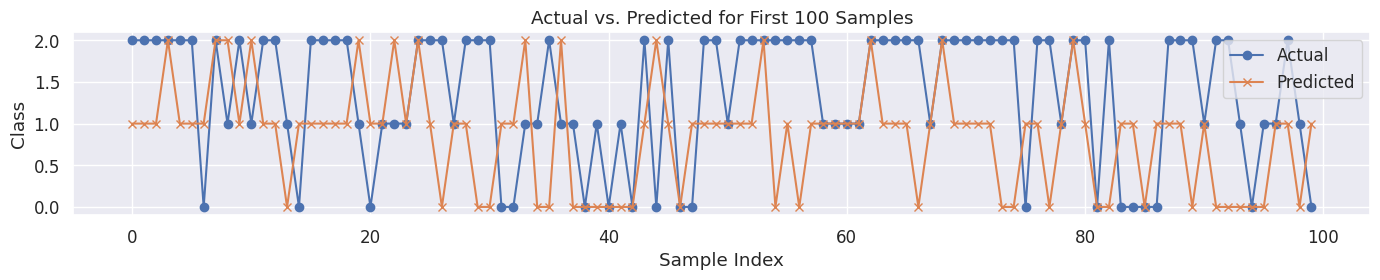


💾 Model saved to enhanced_dnn_ghi_classifier.keras


In [ ]:
# ============================================================
# Cell 9a: Final Enhanced DNN for GHI Category Classification
# Purpose: Mirrors your emotion-detection notebook’s structure
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

print("✅ TensorFlow version:", tf.__version__)

# ── 0. Prepare Data ──────────────────────────────────────────────
# We assume X_tr, X_te (3D windows) and y_tr, y_te (integer labels) come from Cell 7.

# Flatten sliding windows for DNN input
timesteps = X_tr.shape[1]
n_feats   = X_tr.shape[2]
X_train_dnn = X_tr.reshape(-1, timesteps * n_feats)
X_test_dnn  = X_te.reshape(-1, timesteps * n_feats)

# One-hot encode labels
num_classes  = len(np.unique(y_tr))
y_train_cat  = to_categorical(y_tr, num_classes)
y_test_cat   = to_categorical(y_te, num_classes)

# Compute class weights to address imbalance
classes      = np.unique(y_tr)
cw           = compute_class_weight('balanced', classes=classes, y=y_tr)
class_weight = dict(zip(classes, cw))

# ── 1. Build Enhanced DNN ─────────────────────────────────────────
model = Sequential([
    Dense(512, activation='relu', input_shape=(timesteps * n_feats,)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ── 2. Train Model ──────────────────────────────────────────────
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

start_time = time.time()
history = model.fit(
    X_train_dnn, y_train_cat,
    validation_data=(X_test_dnn, y_test_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
print(f"\n⏱ Training time: {time.time() - start_time:.1f}s")

# ── 3. Evaluate on Test Set ─────────────────────────────────────
test_loss, test_acc = model.evaluate(X_test_dnn, y_test_cat, verbose=0)
print(f"\n📊 Test Accuracy: {test_acc:.4f}")
print(f"📊 Test Loss: {test_loss:.4f}")

# ── 4. Training Curves ──────────────────────────────────────────
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Enhanced DNN Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Enhanced DNN Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# ── 5. Predictions and Classification Report ────────────────────
y_pred_probs   = model.predict(X_test_dnn)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_te, y_pred_classes, target_names=label_encoder.classes_))

# ── 6. Confusion Matrix ──────────────────────────────────────────
cm = confusion_matrix(y_te, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ── 7. Predictions Plot ─────────────────────────────────────────
plt.figure(figsize=(14, 3))
plt.plot(y_te[:100], 'o-', label='Actual')
plt.plot(y_pred_classes[:100], 'x-', label='Predicted')
plt.title('Actual vs. Predicted for First 100 Samples')
plt.xlabel('Sample Index'); plt.ylabel('Class')
plt.legend()
plt.tight_layout()
plt.show()

# ── 8. Save Model ───────────────────────────────────────────────
model_path = 'enhanced_dnn_ghi_classifier.keras'
model.save(model_path)
print(f"\n💾 Model saved to {model_path}")


## DNN BASELINE

✅ TensorFlow version: 2.18.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,971 (15.51 KB)

 Trainable params: 3,971 (15.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3977 - loss: 1.1516 - val_accuracy: 0.4750 - val_loss: 1.1337
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5090 - loss: 1.0040 - val_accuracy: 0.4550 - val_loss: 1.0798
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5236 - loss: 0.9841 - val_accuracy: 0.4650 - val_loss: 1.0818
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5360 - loss: 0.9639 - val_accuracy: 0.4700 - val_loss: 1.0731
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5562 - loss: 0.9608 - val_accuracy: 0.4600 - val_loss: 1.0697
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5777 - loss: 0.9230 - val_accuracy: 0.4600 - val_loss: 1.0738
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5436 - loss: 0.9390 - val_accuracy: 0.4450 - val_loss: 1.0688
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5649 - loss: 0.9227 - val_accuracy: 0.4650 - val_loss

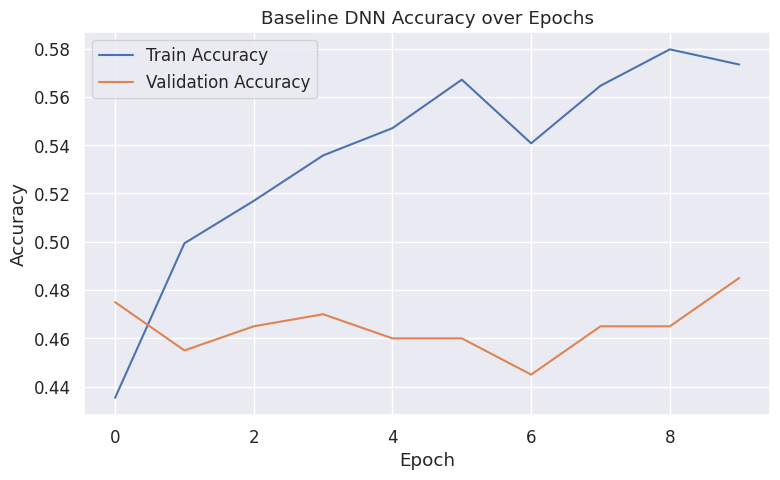

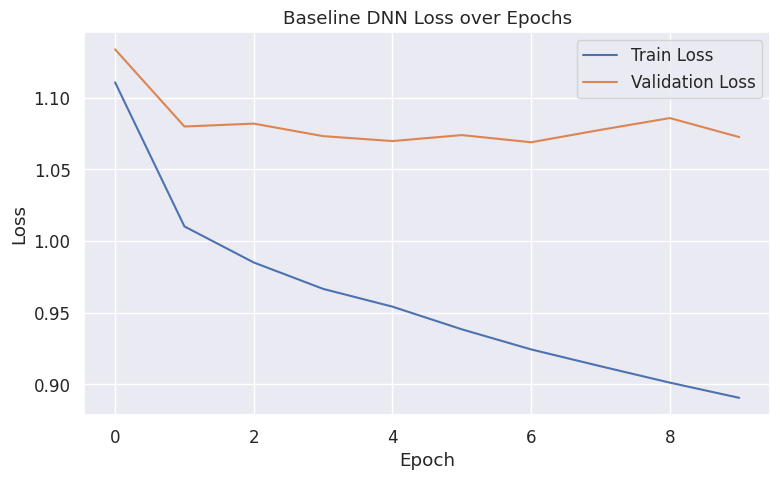

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report (Baseline DNN):
              precision    recall  f1-score   support

        High       0.33      0.03      0.05        36
         Low       0.11      0.03      0.05        62
      Medium       0.48      0.84      0.61       102

    accuracy                           0.45       200
   macro avg       0.31      0.30      0.24       200
weighted avg       0.34      0.45      0.34       200



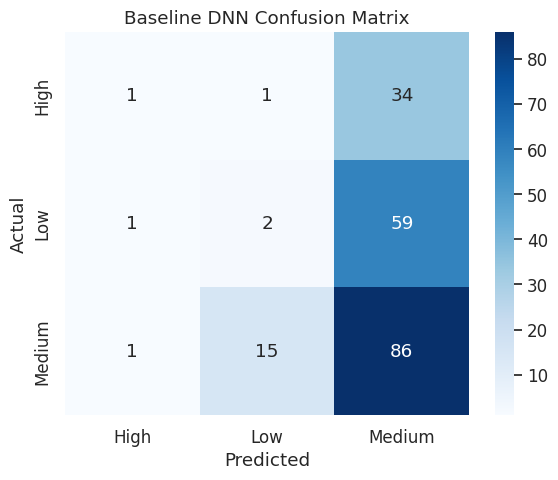


💾 Baseline DNN saved to baseline_dnn_ghi_classifier.keras


In [ ]:
# ============================================================
# Cell 9a: Baseline Dense Neural Network (DNN)
# Purpose: Simple baseline classifier for GHI Category
# ============================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

print("✅ TensorFlow version:", tf.__version__)

# ── 0. Prepare Data ──────────────────────────────────────────────
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test,  num_classes=num_classes)

input_dim = X_train.shape[1]

# ── 1. Build Baseline Model ─────────────────────────────────────
baseline_dnn = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),  # 1st Dense
    Dense(32, activation='relu'),                            # 2nd Dense
    Dense(num_classes, activation='softmax')                 # Output
])

baseline_dnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_dnn.summary()

# ── 2. Train Model ──────────────────────────────────────────────
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = baseline_dnn.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# ── 3. Evaluate on Test Set ─────────────────────────────────────
test_loss, test_acc = baseline_dnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n📊 Baseline DNN Test Accuracy: {test_acc:.4f}")
print(f"📊 Baseline DNN Test Loss: {test_loss:.4f}")

# ── 4. Training Curves ──────────────────────────────────────────
# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline DNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Baseline DNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ── 5. Predictions and Classification Report ────────────────────
y_pred_probs = baseline_dnn.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report (Baseline DNN):")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm_dnn = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Baseline DNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ── 6. Save Model ───────────────────────────────────────────────
dnn_model_path = 'baseline_dnn_ghi_classifier.keras'
baseline_dnn.save(dnn_model_path)
print(f"\n💾 Baseline DNN saved to {dnn_model_path}")


## DNN OPTIMIZED

[I 2025-08-01 00:50:37,678] A new study created in memory with name: no-name-2f41a76a-a7e0-4f07-8dd7-6ed9df645e6d


✅ Sliding Window Prepared: (794, 104), Target Shape: (794,)
Class Weights: {0: 2.0677083333333335, 1: 1.0338541666666667, 2: 0.6455284552845528}
🔍 Running Optuna hyperparameter tuning...


[I 2025-08-01 00:50:54,796] Trial 0 finished with value: 0.4833333194255829 and parameters: {'units1': 126, 'units2': 102, 'units3': 45, 'dropout1': 0.20518582139837893, 'dropout2': 0.35084575161903253, 'dropout3': 0.22218024569946504, 'lr': 0.0005927966200644483, 'batch_size': 32}. Best is trial 0 with value: 0.4833333194255829.
[I 2025-08-01 00:51:09,004] Trial 1 finished with value: 0.32499998807907104 and parameters: {'units1': 140, 'units2': 119, 'units3': 37, 'dropout1': 0.49413168994072987, 'dropout2': 0.3104513450614433, 'dropout3': 0.2553177527805268, 'lr': 0.0004026755769232893, 'batch_size': 128}. Best is trial 0 with value: 0.4833333194255829.
[I 2025-08-01 00:51:18,185] Trial 2 finished with value: 0.4749999940395355 and parameters: {'units1': 87, 'units2': 41, 'units3': 23, 'dropout1': 0.49503797548667194, 'dropout2': 0.4838310829205645, 'dropout3': 0.12388460762568188, 'lr': 0.0035664742167880615, 'batch_size': 32}. Best is trial 0 with value: 0.4833333194255829.
[I 2025

🏆 Best Trial Params: {'units1': 209, 'units2': 45, 'units3': 17, 'dropout1': 0.22239618617022303, 'dropout2': 0.46311343842007363, 'dropout3': 0.3401917875465875, 'lr': 0.003908214295460966, 'batch_size': 128}
Best Validation Accuracy: 0.5417
▶ Training Final Optimized DNN...
Epoch 1/60
6/6 - 4s - 603ms/step - accuracy: 0.3249 - loss: 1.5437 - val_accuracy: 0.3833 - val_loss: 1.0514 - learning_rate: 0.0039
Epoch 2/60
6/6 - 0s - 63ms/step - accuracy: 0.3947 - loss: 1.3056 - val_accuracy: 0.4333 - val_loss: 1.0488 - learning_rate: 0.0039
Epoch 3/60
6/6 - 0s - 56ms/step - accuracy: 0.4080 - loss: 1.2082 - val_accuracy: 0.4000 - val_loss: 1.0586 - learning_rate: 0.0039
Epoch 4/60
6/6 - 0s - 52ms/step - accuracy: 0.4228 - loss: 1.1404 - val_accuracy: 0.4500 - val_loss: 1.0698 - learning_rate: 0.0039
Epoch 5/60
6/6 - 1s - 123ms/step - accuracy: 0.4585 - loss: 1.0993 - val_accuracy: 0.4167 - val_loss: 1.0799 - learning_rate: 0.0039
Epoch 6/60
6/6 - 1s - 89ms/step - accuracy: 0.4050 - loss: 1.

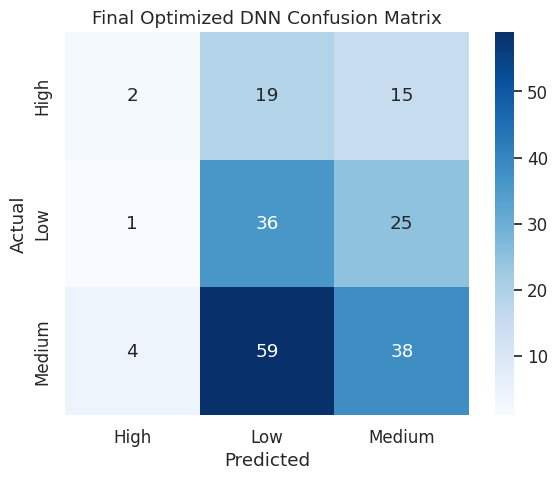

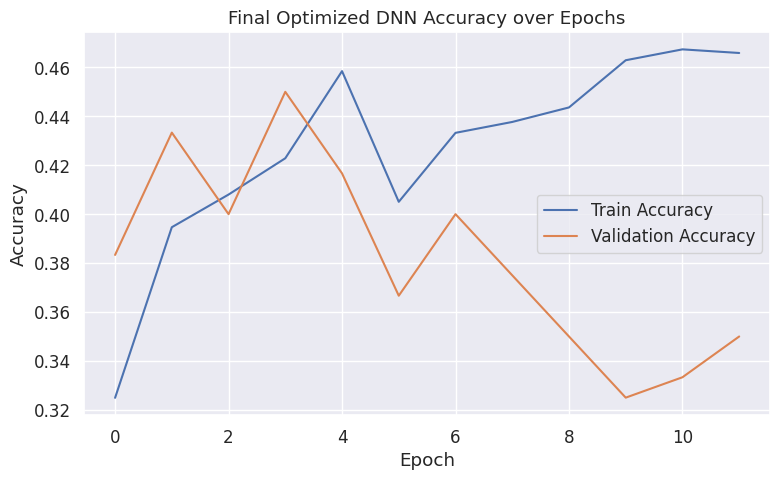

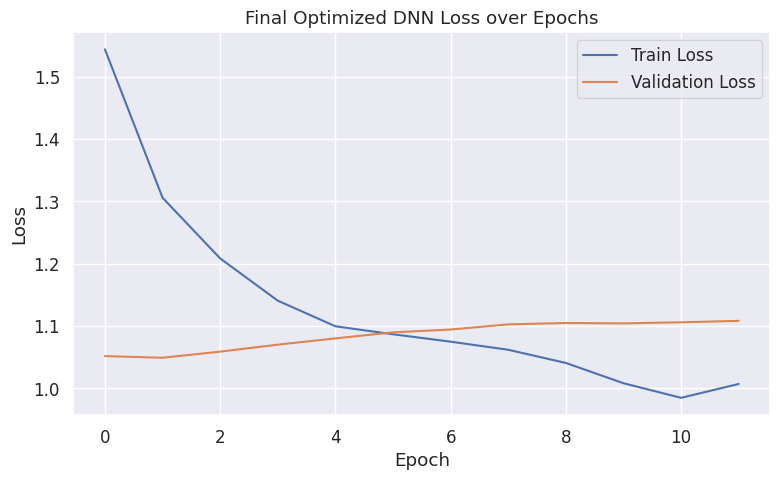


📊 Running SHAP Analysis...


PermutationExplainer explainer: 200it [00:55,  3.45it/s]
/tmp/ipython-input-4190327135.py:186: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_te_seq[:200], feature_names=feature_names, show=True)


Top 10 Features by SHAP:
         Feature  Mean |SHAP|
76    Feature_76     0.018021
242  Feature_242     0.014782
256  Feature_256     0.014714
77    Feature_77     0.013909
238  Feature_238     0.012964
257  Feature_257     0.012455
29    Feature_29     0.012429
43    Feature_43     0.011531
220  Feature_220     0.011522
112  Feature_112     0.011395


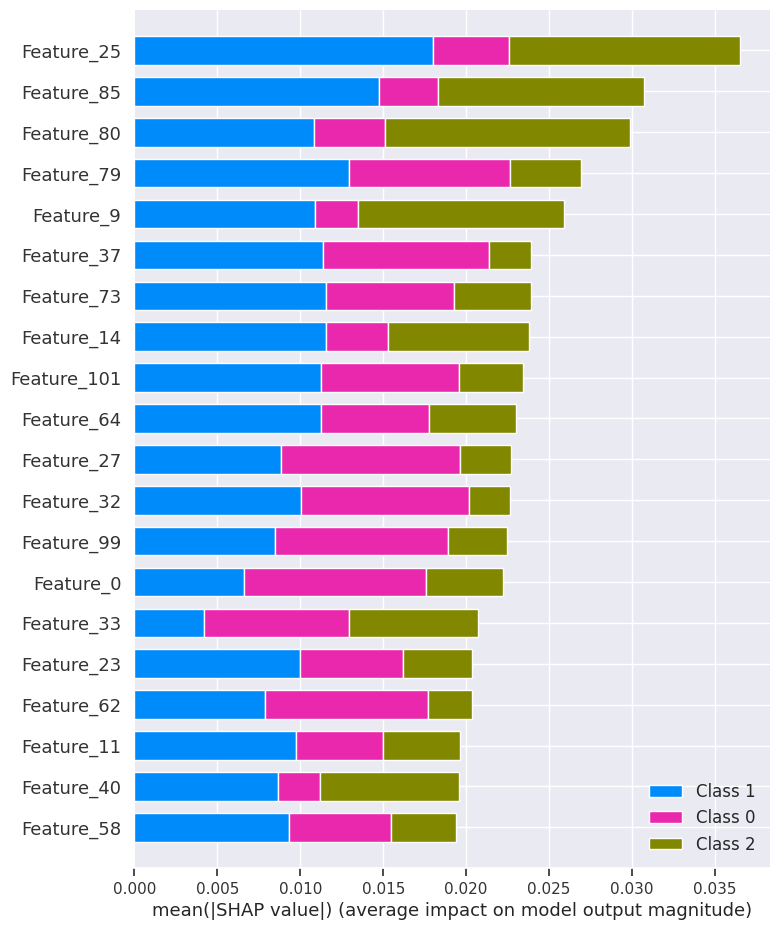

✅ Saved Final Optimized DNN model to 'final_optimized_dnn_timeaware.keras'


In [ ]:
# ============================================================
# Cell 9b: Advanced Optimized Dense Neural Network (Final)
# with Sliding Window + Optuna Hyperparameter Tuning + SHAP
# ============================================================

import optuna
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import shap
import pandas as pd

# 1. Ensure numeric features only
X_num = X_final.select_dtypes(include=[np.number]).copy().astype('float32')

# 2. Sliding Window Feature Creation
def create_sliding_window(X, y, timesteps=4):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X.iloc[i-timesteps:i].values.flatten())
        y_seq.append(y[i])
    return np.array(X_seq, dtype='float32'), np.array(y_seq, dtype='int32')

timesteps = 4  # past 2 hours (4 × 30 min)
X_seq, y_seq = create_sliding_window(X_num, y_final, timesteps)

# Chronological split
train_size = int(0.8 * len(X_seq))
X_tr_seq, X_te_seq = X_seq[:train_size], X_seq[train_size:]
y_tr_seq, y_te_seq = y_seq[:train_size], y_seq[train_size:]
print(f"✅ Sliding Window Prepared: {X_tr_seq.shape}, Target Shape: {y_tr_seq.shape}")

# 3. Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_tr_seq), y=y_tr_seq)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# 4. Define Optuna Objective
def objective(trial):
    model = Sequential(name='Optuna_Tuned_DNN')
    n_units1 = trial.suggest_int('units1', 64, 256)
    n_units2 = trial.suggest_int('units2', 32, 128)
    n_units3 = trial.suggest_int('units3', 16, 64)
    dropout1 = trial.suggest_float('dropout1', 0.2, 0.5)
    dropout2 = trial.suggest_float('dropout2', 0.2, 0.5)
    dropout3 = trial.suggest_float('dropout3', 0.1, 0.4)
    lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    model.add(Dense(n_units1, activation='relu', kernel_regularizer=l2(1e-4),
                    input_shape=(X_tr_seq.shape[1],)))
    model.add(BatchNormalization()); model.add(Dropout(dropout1))
    model.add(Dense(n_units2, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization()); model.add(Dropout(dropout2))
    model.add(Dense(n_units3, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization()); model.add(Dropout(dropout3))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_tr_seq, y_tr_seq,
        validation_split=0.15,
        epochs=30,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        verbose=0,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        ]
    )
    return max(history.history['val_accuracy'])

# 5. Run Optuna
print("🔍 Running Optuna hyperparameter tuning...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)
print("🏆 Best Trial Params:", study.best_trial.params)
print(f"Best Validation Accuracy: {study.best_value:.4f}")

# 6. Train Final Model with Best Params
best_params = study.best_params
final_dnn = Sequential(name='Final_Optimized_DNN')

final_dnn.add(Dense(best_params['units1'], activation='relu', kernel_regularizer=l2(1e-4),
                    input_shape=(X_tr_seq.shape[1],)))
final_dnn.add(BatchNormalization()); final_dnn.add(Dropout(best_params['dropout1']))
final_dnn.add(Dense(best_params['units2'], activation='relu', kernel_regularizer=l2(1e-4)))
final_dnn.add(BatchNormalization()); final_dnn.add(Dropout(best_params['dropout2']))
final_dnn.add(Dense(best_params['units3'], activation='relu', kernel_regularizer=l2(1e-4)))
final_dnn.add(BatchNormalization()); final_dnn.add(Dropout(best_params['dropout3']))
final_dnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

final_dnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['lr']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("▶ Training Final Optimized DNN...")
history_final = final_dnn.fit(
    X_tr_seq, y_tr_seq,
    validation_split=0.15,
    epochs=60,
    batch_size=best_params['batch_size'],
    class_weight=class_weight_dict,
    verbose=2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ]
)

# 7. Evaluate Model
y_pred_probs = final_dnn.predict(X_te_seq)
y_pred = np.argmax(y_pred_probs, axis=1)

acc_final = accuracy_score(y_te_seq, y_pred)
f1_final  = f1_score(y_te_seq, y_pred, average='weighted')
print(f"Final Optimized DNN Accuracy:     {acc_final:.4f}")
print(f"Final Optimized DNN Weighted F1:  {f1_final:.4f}\n")
print("Classification Report:")
print(classification_report(y_te_seq, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_te_seq, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Final Optimized DNN Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 8. Training Curves
plt.figure(figsize=(8,5))
plt.plot(history_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Optimized DNN Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Final Optimized DNN Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 9. SHAP Analysis
print("\n📊 Running SHAP Analysis...")
explainer = shap.Explainer(final_dnn, X_te_seq[:200])
shap_values = explainer(X_te_seq[:200])

shap_mean = np.abs(shap_values.values).mean(axis=0).flatten()

# Generate feature names dynamically
feature_names = []
for t in range(timesteps, 0, -1):
    for col in X_num.columns:
        feature_names.append(f"{col}_t-{t}")

if len(shap_mean) != len(feature_names):
    feature_names = [f"Feature_{i}" for i in range(len(shap_mean))]

shap_importance = pd.DataFrame({
    "Feature": feature_names,
    "Mean |SHAP|": shap_mean
}).sort_values("Mean |SHAP|", ascending=False)

print("Top 10 Features by SHAP:")
print(shap_importance.head(10))

shap.summary_plot(shap_values, X_te_seq[:200], feature_names=feature_names, show=True)

# 10. Save Final Model
final_dnn.save('final_optimized_dnn_timeaware.keras')
print("✅ Saved Final Optimized DNN model to 'final_optimized_dnn_timeaware.keras'")



# LSTM Baseline LSTM (32 units, 10 epochs)

✅ Data reshaped for LSTM: (797, 1, 26), (200, 1, 26)


Model: "Baseline_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputSeq (InputLayer)           │ (None, 1, 26)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM32 (LSTM)                   │ (None, 32)             │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,651 (29.89 KB)

 Trainable params: 7,651 (29.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
23/23 - 5s - 229ms/step - accuracy: 0.3250 - loss: 1.1175 - val_accuracy: 0.3125 - val_loss: 1.0564
Epoch 2/10
23/23 - 1s - 25ms/step - accuracy: 0.3250 - loss: 1.0587 - val_accuracy: 0.3125 - val_loss: 0.9993
Epoch 3/10
23/23 - 1s - 29ms/step - accuracy: 0.4073 - loss: 1.0304 - val_accuracy: 0.5750 - val_loss: 0.9712
Epoch 4/10
23/23 - 1s - 54ms/step - accuracy: 0.5091 - loss: 1.0165 - val_accuracy: 0.5750 - val_loss: 0.9563
Epoch 5/10
23/23 - 1s - 49ms/step - accuracy: 0.5091 - loss: 1.0104 - val_accuracy: 0.5750 - val_loss: 0.9492
Epoch 6/10
23/23 - 1s - 25ms/step - accuracy: 0.5091 - loss: 1.0083 - val_accuracy: 0.5750 - val_loss: 0.9452
Epoch 7/10
23/23 - 1s - 22ms/step - accuracy: 0.5091 - loss: 1.0075 - val_accuracy: 0.5750 - val_loss: 0.9433
Epoch 8/10
23/23 - 0s - 7ms/step - accuracy: 0.5091 - loss: 1.0074 - val_accuracy: 0.5750 - val_loss: 0.9418
Epoch 9/10
23/23 - 0s - 12ms/step - accuracy: 0.5091 - loss: 1.0075 - val_accuracy: 0.5750 - val_loss: 0.9425
Epoch 10/1

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Baseline LSTM Accuracy:    0.5100
Baseline LSTM Weighted F1: 0.3445

Baseline LSTM Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.00      0.00      0.00        62
      Medium       0.51      1.00      0.68       102

    accuracy                           0.51       200
   macro avg       0.17      0.33      0.23       200
weighted avg       0.26      0.51      0.34       200



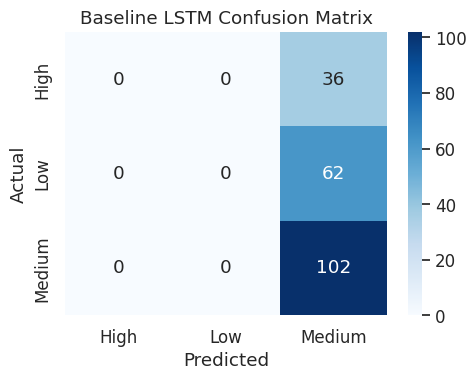

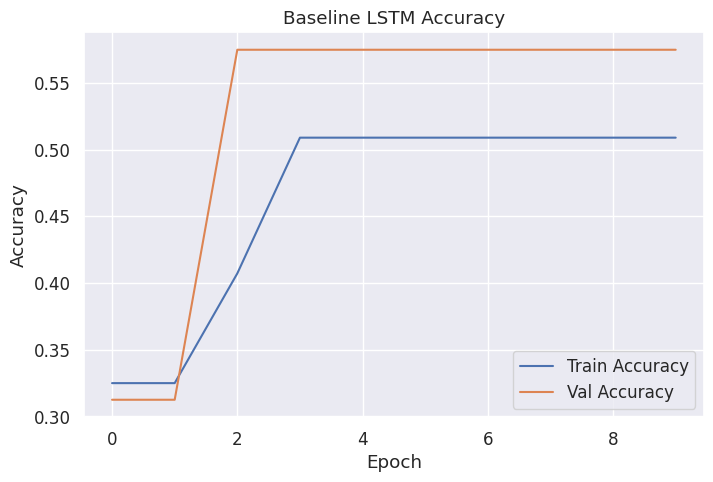

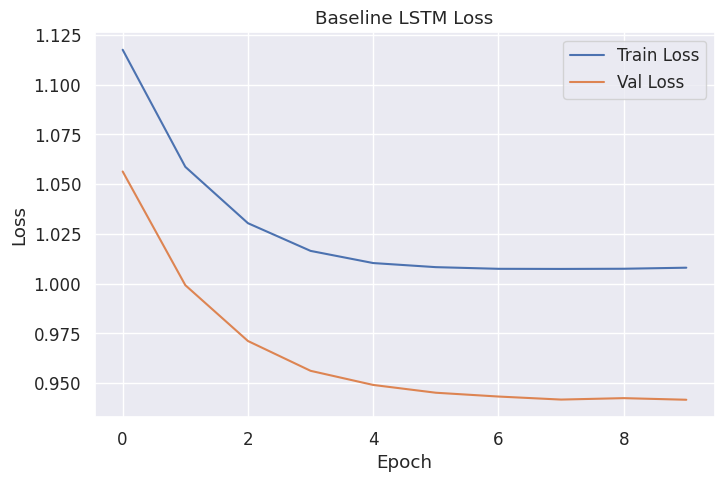

🔹 Saved Baseline LSTM model to 'baseline_lstm_ghi_classifier.keras'


In [ ]:
# ============================================================
# Cell 10a: Baseline LSTM (Fixed Column Mismatch)
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ---- 1. Ensure same feature set as scaler ----
# If you saved numeric_cols earlier:
if "numeric_cols" in globals():
    X_tr_aligned = X_train[numeric_cols]
    X_te_aligned = X_test[numeric_cols]
else:
    # fallback: drop non-numeric
    X_tr_aligned = X_train.select_dtypes(include=[np.number])
    X_te_aligned = X_test.select_dtypes(include=[np.number])

X_tr_scaled = scaler.transform(X_tr_aligned)
X_te_scaled = scaler.transform(X_te_aligned)

y_tr = np.array(y_train, dtype=int)
y_te = np.array(y_test, dtype=int)

timesteps  = 1
n_features = X_tr_scaled.shape[1]

X_tr_seq   = X_tr_scaled.reshape((-1, timesteps, n_features))
X_te_seq   = X_te_scaled.reshape((-1, timesteps, n_features))

print(f"✅ Data reshaped for LSTM: {X_tr_seq.shape}, {X_te_seq.shape}")

# ---- 2. Build baseline LSTM ----
inputs = Input(shape=(timesteps, n_features), name='InputSeq')
x = LSTM(32, name='LSTM32')(inputs)
outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

baseline_lstm = Model(inputs, outputs, name='Baseline_LSTM')
baseline_lstm.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
baseline_lstm.summary()

# ---- 3. Train baseline LSTM ----
start = time.time()
history_lstm_base = baseline_lstm.fit(
    X_tr_seq, y_tr,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=2
)
print(f"\n🔹 Baseline LSTM trained in {time.time() - start:.2f}s")

# ---- 4. Evaluate baseline LSTM ----
y_pred_lstm_base = np.argmax(baseline_lstm.predict(X_te_seq), axis=1)
acc_lstm_base = accuracy_score(y_te, y_pred_lstm_base)
f1_lstm_base = f1_score(y_te, y_pred_lstm_base, average='weighted')

print(f"Baseline LSTM Accuracy:    {acc_lstm_base:.4f}")
print(f"Baseline LSTM Weighted F1: {f1_lstm_base:.4f}\n")
print("Baseline LSTM Classification Report:")
print(classification_report(y_te, y_pred_lstm_base, target_names=label_encoder.classes_))

# ---- 5. Confusion Matrix ----
cm_lstm_base = confusion_matrix(y_te, y_pred_lstm_base)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lstm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Baseline LSTM Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ---- 6. Accuracy & Loss Plots ----
plt.figure(figsize=(8,5))
plt.plot(history_lstm_base.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_base.history['val_accuracy'], label='Val Accuracy')
plt.title('Baseline LSTM Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_lstm_base.history['loss'], label='Train Loss')
plt.plot(history_lstm_base.history['val_loss'], label='Val Loss')
plt.title('Baseline LSTM Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.show()

# ---- 7. Save baseline LSTM ----
baseline_lstm.save('baseline_lstm_ghi_classifier.keras')
print("🔹 Saved Baseline LSTM model to 'baseline_lstm_ghi_classifier.keras'")


## LSTM OPTIMIZED

✅ Optimized LSTM data prepared: (797, 1, 26), (200, 1, 26)


Model: "Optimized_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Sequence (InputLayer)     │ (None, 1, 26)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer (LSTM)               │ (None, 64)             │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm (BatchNormalization)  │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,731 (100.51 KB)

 Trainable params: 25,603 (100.01 KB)

 Non-trainable params: 128 (512.00 B)

▶ Training Optimized LSTM…
Epoch 1/60
23/23 - 12s - 529ms/step - accuracy: 0.4045 - loss: 1.2222 - val_accuracy: 0.3125 - val_loss: 1.0550 - learning_rate: 0.0010
Epoch 2/60
23/23 - 3s - 115ms/step - accuracy: 0.4435 - loss: 1.1469 - val_accuracy: 0.5750 - val_loss: 0.9913 - learning_rate: 0.0010
Epoch 3/60
23/23 - 1s - 28ms/step - accuracy: 0.4491 - loss: 1.1360 - val_accuracy: 0.5750 - val_loss: 0.9981 - learning_rate: 0.0010
Epoch 4/60
23/23 - 0s - 17ms/step - accuracy: 0.4672 - loss: 1.1069 - val_accuracy: 0.3125 - val_loss: 0.9964 - learning_rate: 0.0010
Epoch 5/60
23/23 - 0s - 14ms/step - accuracy: 0.4463 - loss: 1.0955 - val_accuracy: 0.5750 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 6/60
23/23 - 0s - 16ms/step - accuracy: 0.4491 - loss: 1.1122 - val_accuracy: 0.5750 - val_loss: 1.0006 - learning_rate: 0.0010
Epoch 7/60
23/23 - 1s - 24ms/step - accuracy: 0.4616 - loss: 1.0837 - val_accuracy: 0.5750 - val_loss: 0.9547 - learning_rate: 0.0010
Epoch 8/60
23/23 - 1s - 22ms/ste

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Optimized LSTM Accuracy:     0.5100
Optimized LSTM Weighted F1:  0.3445

Optimized LSTM Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.00      0.00      0.00        62
      Medium       0.51      1.00      0.68       102

    accuracy                           0.51       200
   macro avg       0.17      0.33      0.23       200
weighted avg       0.26      0.51      0.34       200



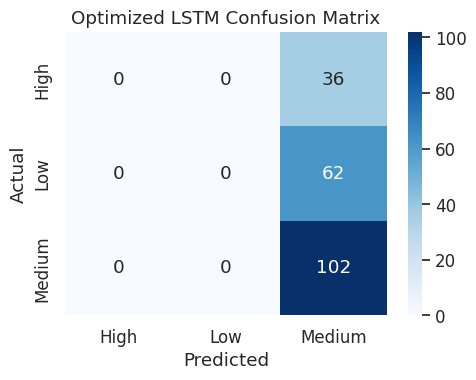

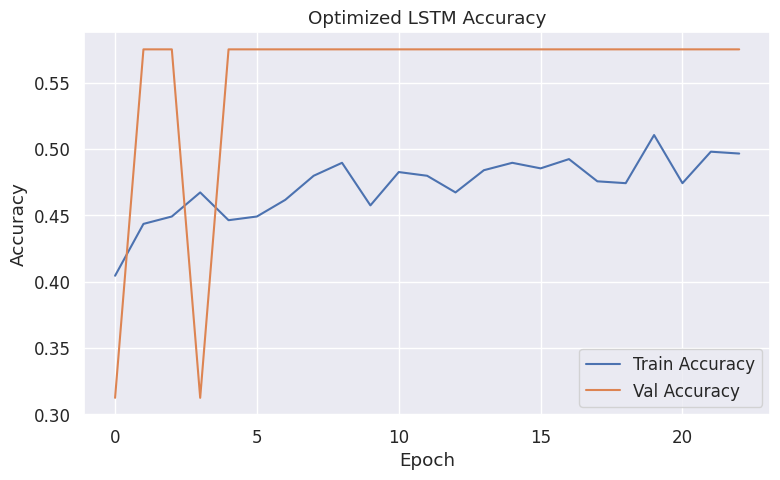

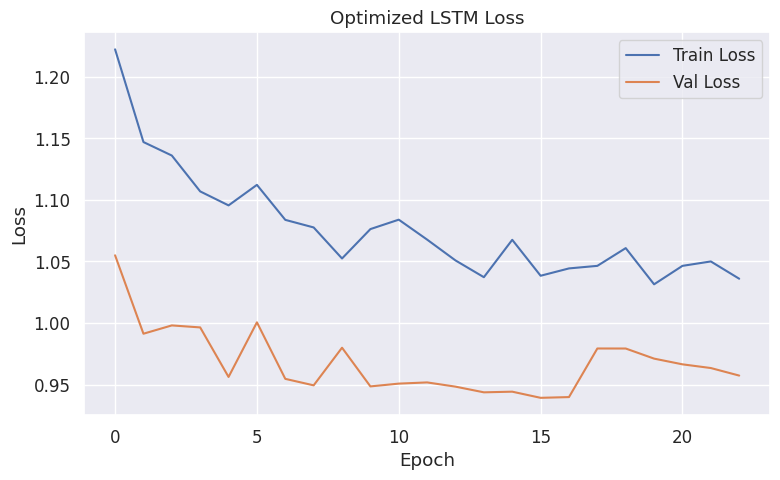

✅ Saved Optimized LSTM model to 'optimized_lstm_ghi_classifier.keras'


In [ ]:
# ============================================================
# Cell 10b: Optimized LSTM – Training + Evaluation + Plots
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ---- 1. Align features with scaler ----
if "numeric_cols" in globals():
    X_tr_aligned = X_train[numeric_cols]
    X_te_aligned = X_test[numeric_cols]
else:
    X_tr_aligned = X_train.select_dtypes(include=[np.number])
    X_te_aligned = X_test.select_dtypes(include=[np.number])

X_tr_np = scaler.transform(X_tr_aligned).astype('float32')
X_te_np = scaler.transform(X_te_aligned).astype('float32')
y_tr = np.array(y_train, dtype=int)
y_te = np.array(y_test, dtype=int)

# ---- 2. Reshape for LSTM ----
timesteps  = 1
n_features = X_tr_np.shape[1]
X_tr_seq   = X_tr_np.reshape(-1, timesteps, n_features)
X_te_seq   = X_te_np.reshape(-1, timesteps, n_features)

print(f"✅ Optimized LSTM data prepared: {X_tr_seq.shape}, {X_te_seq.shape}")

# ---- 3. Build optimized LSTM ----
inputs = Input(shape=(timesteps, n_features), name='Input_Sequence')
x = LSTM(
    64,
    kernel_regularizer=l2(1e-4),
    recurrent_regularizer=l2(1e-4),
    dropout=0.2,
    recurrent_dropout=0.2,
    name='LSTM_Layer'
)(inputs)
x = BatchNormalization(name='BatchNorm')(x)
x = Dense(32, activation='relu', name='Dense_1')(x)
x = Dropout(0.3, name='Dropout')(x)
outputs = Dense(len(label_encoder.classes_), activation='softmax', name='Output')(x)

opt_lstm = Model(inputs, outputs, name='Optimized_LSTM')
opt_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
opt_lstm.summary()

# ---- 4. Train with callbacks ----
print("▶ Training Optimized LSTM…")
start = time.time()
history_lstm = opt_lstm.fit(
    X_tr_seq, y_tr,
    validation_split=0.1,
    epochs=60,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ],
    verbose=2
)
train_time = time.time() - start
print(f"✔ Optimized LSTM trained in {train_time:.2f}s")

# ---- 5. Evaluate optimized LSTM ----
y_pred_lstm = np.argmax(opt_lstm.predict(X_te_seq), axis=1)
acc_lstm    = accuracy_score(y_te, y_pred_lstm)
f1_lstm     = f1_score(y_te, y_pred_lstm, average='weighted')

print(f"Optimized LSTM Accuracy:     {acc_lstm:.4f}")
print(f"Optimized LSTM Weighted F1:  {f1_lstm:.4f}\n")
print("Optimized LSTM Classification Report:")
print(classification_report(y_te, y_pred_lstm, target_names=label_encoder.classes_))

# ---- 6. Confusion Matrix ----
cm_lstm = confusion_matrix(y_te, y_pred_lstm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Optimized LSTM Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ---- 7. Accuracy & Loss Plots ----
plt.figure(figsize=(8,5))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Optimized LSTM Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Optimized LSTM Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---- 8. Save optimized LSTM ----
opt_lstm.save('optimized_lstm_ghi_classifier.keras')
print("✅ Saved Optimized LSTM model to 'optimized_lstm_ghi_classifier.keras'")


✅ Feature list loaded from training.
✅ Using scaler's feature_names_in_ for alignment.

📊 Random Forest Evaluation:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.38      0.16      0.23        62
      Medium       0.51      0.84      0.63       102

    accuracy                           0.48       200
   macro avg       0.30      0.33      0.29       200
weighted avg       0.38      0.48      0.39       200



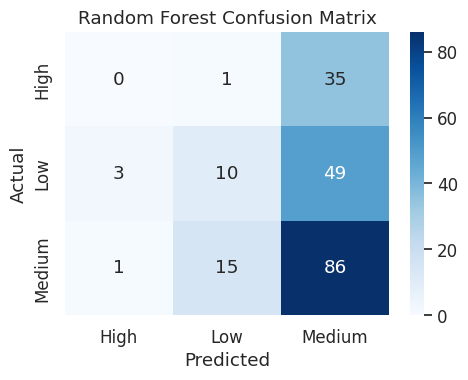


📊 XGBoost Evaluation:
              precision    recall  f1-score   support

        High       0.17      0.11      0.13        36
         Low       0.33      0.34      0.34        62
      Medium       0.49      0.54      0.51       102

    accuracy                           0.40       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.38      0.40      0.39       200



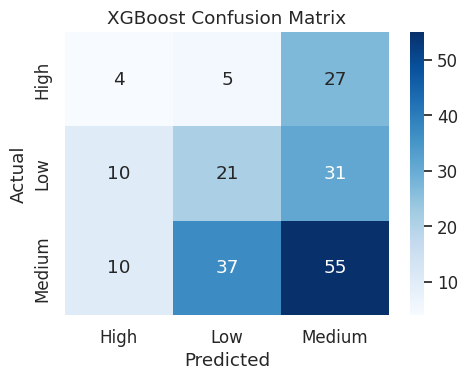


📊 LSTM Evaluation:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.00      0.00      0.00        62
      Medium       0.51      1.00      0.68       102

    accuracy                           0.51       200
   macro avg       0.17      0.33      0.23       200
weighted avg       0.26      0.51      0.34       200



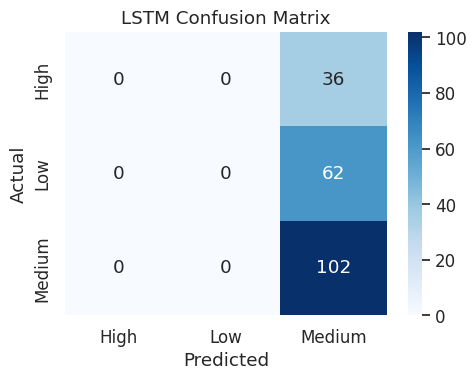


✅ Summary of Model Performance:


,Accuracy,F1
Random Forest,0.48,0.3930
XGBoost,0.40,0.3891
LSTM,0.51,0.3445


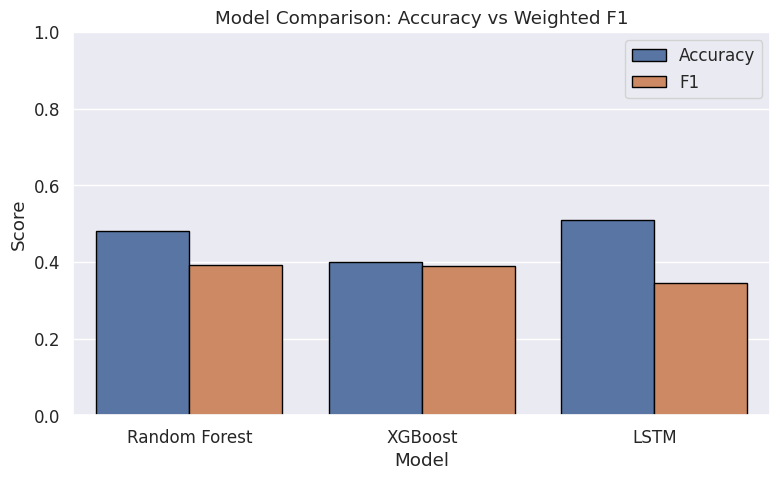

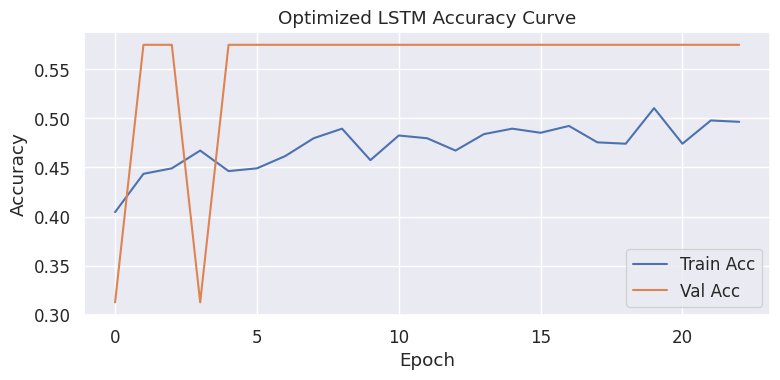

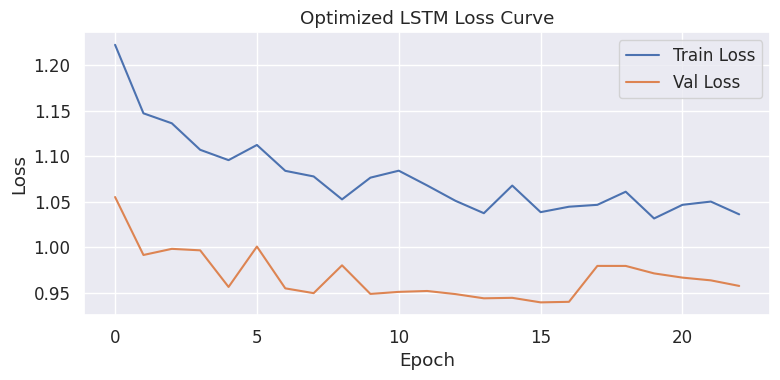

In [ ]:
# ============================================================
# Cell 11: Model Evaluation & Comparison with Visualizations
# ============================================================

import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf

sns.set_context("notebook", font_scale=1.1)

# ---- 1. Load models & artifacts safely ----
def safe_load_joblib(path):
    try:
        return joblib.load(path)
    except Exception as e:
        print(f"⚠️ Could not load {path}: {e}")
        return None

def safe_load_keras(path):
    try:
        return tf.keras.models.load_model(path)
    except Exception as e:
        print(f"⚠️ Could not load {path}: {e}")
        return None

rf = safe_load_joblib('rf_model_ghi_class.pkl')
xgb = safe_load_joblib('xgb_advanced_model.pkl')
lstm = safe_load_keras('optimized_lstm_ghi_classifier.keras')
scaler = safe_load_joblib('scaler.pkl')
label_encoder = safe_load_joblib('label_encoder.pkl')

# Load feature list (used for reference, not necessarily for scaling)
try:
    with open('feature_list_xgb.json', 'r') as f:
        feature_list = json.load(f)
    print("✅ Feature list loaded from training.")
except Exception as e:
    feature_list = None
    print(f"⚠️ feature_list_xgb.json not found or unreadable: {e}")

# ---- 2. Determine scaler feature names to avoid mismatch ----
if scaler is None:
    raise RuntimeError("Scaler not loaded; cannot proceed.")

if hasattr(scaler, "feature_names_in_"):
    scaler_features = list(scaler.feature_names_in_)
    print("✅ Using scaler's feature_names_in_ for alignment.")
elif "numeric_cols" in globals():
    scaler_features = numeric_cols
    print("⚠️ scaler has no feature_names_in_, falling back to stored numeric_cols.")
else:
    scaler_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    print("⚠️ Falling back to numeric columns from X_train.")

# ---- 3. Prepare test data for each model ----
# Base test targets
y_te = np.array(y_test, dtype=int)

# For tree models: align their expected features individually
def align_df(df, cols):
    return df.reindex(columns=cols, fill_value=0)

# For neural models: scale using correct columns
X_te_for_scaling = X_test.reindex(columns=scaler_features, fill_value=0)
X_te_scaled = scaler.transform(X_te_for_scaling).astype("float32")
X_te_seq = X_te_scaled.reshape(-1, 1, X_te_scaled.shape[1])  # for LSTM

# ---- 4. Evaluation per model ----
metrics = {}

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Random Forest
if rf is not None:
    print("\n📊 Random Forest Evaluation:")
    # align with what RF was trained on
    if hasattr(rf, "feature_names_in_"):
        X_rf = align_df(X_test, rf.feature_names_in_)
    else:
        X_rf = align_df(X_test, scaler_features)
    y_pred_rf = rf.predict(X_rf)
    acc_rf = accuracy_score(y_te, y_pred_rf)
    f1_rf = f1_score(y_te, y_pred_rf, average='weighted')
    metrics["Random Forest"] = {"Accuracy": acc_rf, "F1": f1_rf}
    print(classification_report(y_te, y_pred_rf, target_names=label_encoder.classes_))
    plot_conf_matrix(y_te, y_pred_rf, "Random Forest")

# XGBoost
if xgb is not None:
    print("\n📊 XGBoost Evaluation:")
    if hasattr(xgb, "feature_names_in_"):
        X_xgb = align_df(X_test, xgb.feature_names_in_)
    else:
        X_xgb = align_df(X_test, scaler_features)
    y_pred_xgb = xgb.predict(X_xgb)
    acc_xgb = accuracy_score(y_te, y_pred_xgb)
    f1_xgb = f1_score(y_te, y_pred_xgb, average='weighted')
    metrics["XGBoost"] = {"Accuracy": acc_xgb, "F1": f1_xgb}
    print(classification_report(y_te, y_pred_xgb, target_names=label_encoder.classes_))
    plot_conf_matrix(y_te, y_pred_xgb, "XGBoost")

# LSTM
if lstm is not None:
    print("\n📊 LSTM Evaluation:")
    y_pred_lstm = np.argmax(lstm.predict(X_te_seq), axis=1)
    acc_lstm = accuracy_score(y_te, y_pred_lstm)
    f1_lstm = f1_score(y_te, y_pred_lstm, average='weighted')
    metrics["LSTM"] = {"Accuracy": acc_lstm, "F1": f1_lstm}
    print(classification_report(y_te, y_pred_lstm, target_names=label_encoder.classes_))
    plot_conf_matrix(y_te, y_pred_lstm, "LSTM")

# ---- 5. Summary table ----
print("\n✅ Summary of Model Performance:")
summary_df = pd.DataFrame(metrics).T
display(summary_df.round(4))

# ---- 6. Comparison grouped bar chart ----
if summary_df.shape[0] > 0:
    df_plot = summary_df.reset_index().melt(id_vars="index", value_vars=["Accuracy", "F1"],
                                           var_name="Metric", value_name="Score")
    df_plot.rename(columns={"index": "Model"}, inplace=True)

    plt.figure(figsize=(8,5))
    sns.barplot(data=df_plot, x="Model", y="Score", hue="Metric", edgecolor="black")
    plt.title("Model Comparison: Accuracy vs Weighted F1")
    plt.ylim(0, 1)
    plt.legend(title="")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.show()

# ---- 7. Optional: plot LSTM training curves if history object exists ----
if 'history_lstm' in globals():
    hist = history_lstm.history
    plt.figure(figsize=(8,4))
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title("Optimized LSTM Accuracy Curve")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title("Optimized LSTM Loss Curve")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## Time-Series Cross-Validation for Final Champion Model


🔁 Running TimeSeriesSplit (5 folds) CV on champion model: XGB

Fold 1: Accuracy=0.3554, Weighted F1=0.3489
              precision    recall  f1-score   support

        High       0.12      0.08      0.10        36
         Low       0.25      0.30      0.27        46
      Medium       0.49      0.50      0.50        84

    accuracy                           0.36       166
   macro avg       0.29      0.30      0.29       166
weighted avg       0.35      0.36      0.35       166

------------------------------------------------------------
Fold 2: Accuracy=0.3855, Weighted F1=0.3920
              precision    recall  f1-score   support

        High       0.19      0.37      0.25        27
         Low       0.37      0.24      0.29        59
      Medium       0.53      0.50      0.52        80

    accuracy                           0.39       166
   macro avg       0.36      0.37      0.35       166
weighted avg       0.42      0.39      0.39       166

--------------------------

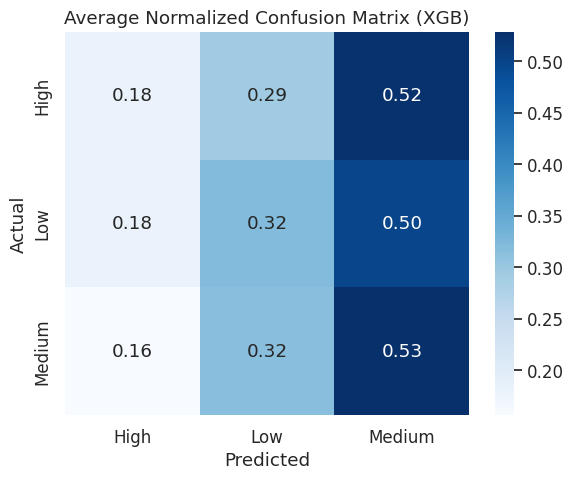

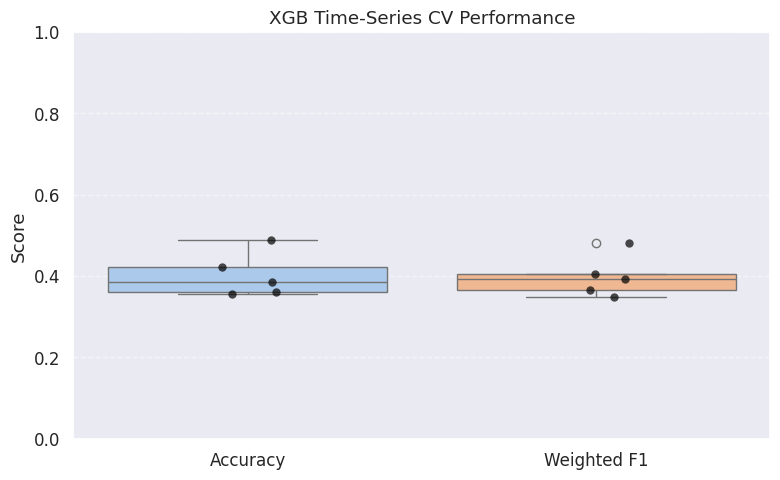

In [ ]:
# ============================================================
# Cell 12: Time-Series Cross-Validation for Final Champion Model
# (supports 'xgb' or 'rf'; handles Cloud_Type / non-numeric safely)
# ============================================================

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

sns.set_context("notebook", font_scale=1.1)

# -------- USER CHOICE: set champion model key to 'xgb' or 'rf' --------
champion_key = 'xgb'  # change to 'rf' if Random Forest is the champion

# -------- Prepare feature matrix and target --------
if 'X_final' not in globals() or 'y_final' not in globals():
    raise RuntimeError("X_final or y_final missing; run Feature Engineering cell to set them.")

# Work on a copy and drop original object columns that were not numeric (e.g., raw Cloud_Type)
X = X_final.copy()
# If raw categorical columns like 'Cloud_Type' exist, drop them; keep encoded versions
for col in X.select_dtypes(include=['object']).columns.tolist():
    X.drop(columns=[col], inplace=True)

y = y_final.copy()  # integer encoded target

# -------- Load base (trained) model to extract parameters --------
if champion_key == 'xgb':
    base_model = joblib.load('xgb_advanced_model.pkl')
    from xgboost import XGBClassifier

    # Extract parameters, ensure required settings
    params = base_model.get_params()
    # Force consistency
    params.update({
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'n_jobs': -1
    })

    def make_model():
        return XGBClassifier(**params)

elif champion_key == 'rf':
    base_model = joblib.load('rf_model_ghi_class.pkl')
    from sklearn.ensemble import RandomForestClassifier

    params = base_model.get_params()
    # Ensure class_weight and randomness are consistent
    def make_model():
        return RandomForestClassifier(**params)

else:
    raise ValueError("champion_key must be 'xgb' or 'rf'.")

# -------- TimeSeriesSplit setup --------
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
accs = []
f1s = []
cms = []
fold = 0

print(f"🔁 Running TimeSeriesSplit ({n_splits} folds) CV on champion model: {champion_key.upper()}\n")

for train_idx, val_idx in tscv.split(X):
    fold += 1
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    # Compute class weights for this fold
    classes_unique = np.unique(y_train_cv)
    cw = compute_class_weight('balanced', classes=classes_unique, y=y_train_cv)
    class_weight_dict = dict(zip(classes_unique, cw))
    sample_w = np.array([class_weight_dict[c] for c in y_train_cv])

    model = make_model()

    # Fit with appropriate sample weighting
    if champion_key == 'xgb':
        model.fit(
            X_train_cv, y_train_cv,
            sample_weight=sample_w,
            verbose=False
        )
    else:  # Random Forest
        # RandomForestClassifier expects class_weight param inside constructor; already encoded in params if present
        model.fit(X_train_cv, y_train_cv)

    # Predict and evaluate
    y_pred_cv = model.predict(X_val_cv)
    acc = accuracy_score(y_val_cv, y_pred_cv)
    f1w = f1_score(y_val_cv, y_pred_cv, average='weighted')
    accs.append(acc)
    f1s.append(f1w)
    cm = confusion_matrix(y_val_cv, y_pred_cv, labels=np.unique(y))
    cms.append(cm)

    print(f"Fold {fold}: Accuracy={acc:.4f}, Weighted F1={f1w:.4f}")
    print(classification_report(y_val_cv, y_pred_cv, target_names=label_encoder.classes_))
    print("-" * 60)

# -------- Aggregate results --------
acc_mean, acc_std = np.mean(accs), np.std(accs)
f1_mean, f1_std = np.mean(f1s), np.std(f1s)
print(f"\n📌 Cross-validation summary for {champion_key.upper()}:")
print(f"Accuracy:    {acc_mean:.4f} ± {acc_std:.4f}")
print(f"Weighted F1: {f1_mean:.4f} ± {f1_std:.4f}")

# -------- Average normalized confusion matrix --------
sum_cm = np.sum(cms, axis=0)
norm_cm = sum_cm.astype(float)
row_sums = norm_cm.sum(axis=1, keepdims=True)
norm_cm = np.divide(norm_cm, row_sums, where=row_sums != 0)

plt.figure(figsize=(6,5))
sns.heatmap(
    norm_cm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title(f"Average Normalized Confusion Matrix ({champion_key.upper()})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# -------- Fold performance boxplot --------
df_metrics = pd.DataFrame({
    "Accuracy": accs,
    "Weighted F1": f1s
}, index=[f"Fold {i+1}" for i in range(len(accs))])

plt.figure(figsize=(8,5))
sns.boxplot(data=df_metrics, palette="pastel")
sns.stripplot(data=df_metrics, color="black", size=6, jitter=True, alpha=0.7)
plt.title(f"{champion_key.upper()} Time-Series CV Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##  Explainability & Feature Interpretability


✅ Loaded feature_list_xgb.json


 99%|===================| 595/600 [00:44<00:00]       

⚠️ SHAP failed for Random Forest (Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.271729, while the model output was 0.285534. If this difference is acceptable you can set check_additivity=False to disable this check.); falling back to built-in importances.


100%|===================| 597/600 [00:38<00:00]       

⚠️ SHAP failed for XGBoost (Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 1.466667, while the model output was 1.397668. If this difference is acceptable you can set check_additivity=False to disable this check.); falling back to built-in importances.

🔁 Permutation importance (RF, XGBoost)

Top 8 permutation importances for Random Forest:


,Feature,Mean Importance,Std
24,GHI_lag2,0.0150,0.0050
3,DNI_W_m²,0.0075,0.0157
22,cos_zenith,0.0070,0.0112
10,Cloud_Type,0.0050,0.0059
23,GHI_lag1,0.0050,0.0077
12,Cloud_Type_Encoded,0.0025,0.0084
14,Hour_sin,0.0020,0.0078
21,Temp_x_RH,0.0015,0.0095



Top 8 permutation importances for XGBoost:


,Feature,Mean Importance,Std
24,GHI_lag2,0.0055,0.0104
10,Cloud_Type,0.0045,0.0072
5,Temp_°C,0.0040,0.0097
22,cos_zenith,0.0040,0.0107
12,Cloud_Type_Encoded,0.0005,0.0052
18,Month,0.0000,0.0000
16,DayOfYear,0.0000,0.0000
19,Month_sin,0.0000,0.0000



📈 Partial dependence plots for top features (XGBoost SHAP): ['Hour_cos', 'GHI_diff_past', 'Wind_Speed_m_s']


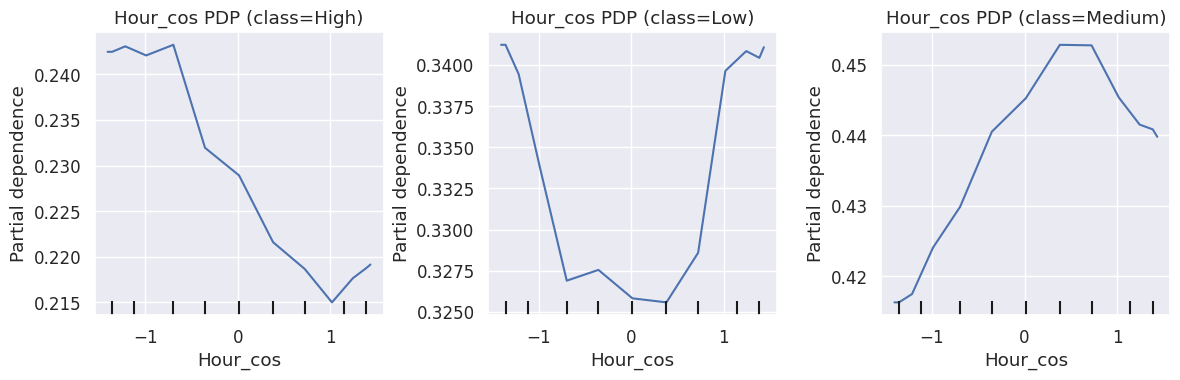

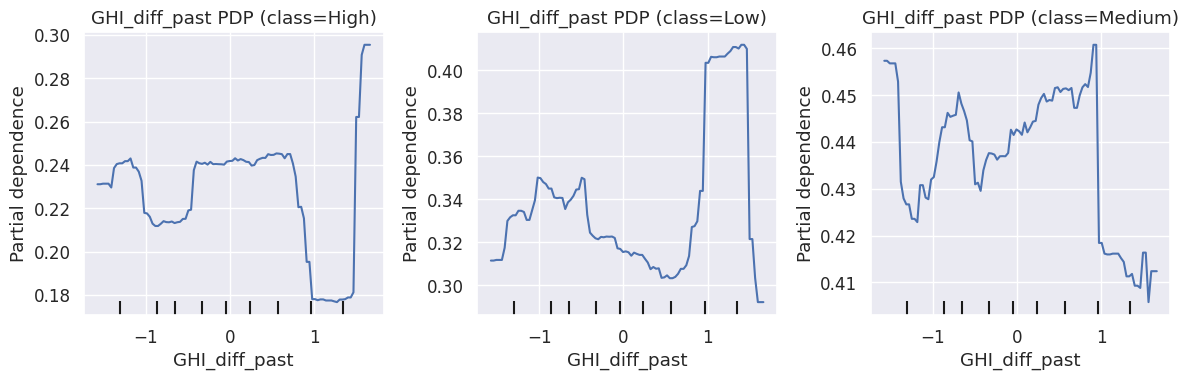

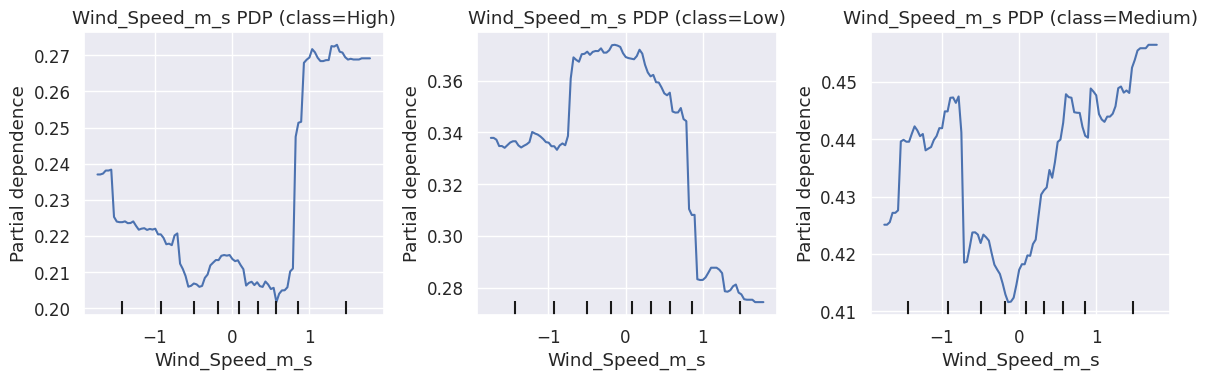


🔍 Feature importance comparison (SHAP vs Permutation):


,Random Forest SHAP,Random Forest Permutation,XGBoost SHAP,XGBoost Permutation
0,0.0565,0.0000,0.0422,0.0000
1,0.0521,0.0010,0.0422,0.0000
2,0.0490,0.0000,NaN,NaN
3,0.0499,0.0075,NaN,NaN
6,0.0537,0.0000,0.0423,0.0000
7,0.0555,0.0000,0.0426,0.0000
9,0.0581,0.0000,0.0452,0.0000
10,0.0000,0.0050,0.0000,0.0045
11,0.0000,0.0015,0.0432,0.0000
12,0.0000,0.0025,0.0000,0.0005



🧪 SHAP dependence plot for 'Hour_cos' (XGBoost):


 98%|===================| 589/600 [00:37<00:00]       

Could not generate dependence plot for Hour_cos: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 1.461432, while the model output was 1.397668. If this difference is acceptable you can set check_additivity=False to disable this check.


In [ ]:
# ============================================================
# Cell 13: Explainability & Feature Interpretability (Fixed)
# ============================================================

import joblib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.1)

# ---- 1. Load models/artifacts (reuse if in memory) ----
rf = rf if 'rf' in globals() else joblib.load("rf_model_ghi_class.pkl")
xgb = xgb if 'xgb' in globals() else joblib.load("xgb_advanced_model.pkl")
scaler = scaler if 'scaler' in globals() else joblib.load("scaler.pkl")
label_encoder = label_encoder if 'label_encoder' in globals() else joblib.load("label_encoder.pkl")

# ---- 2. Determine base features for evaluation (consistent with training) ----
try:
    with open("feature_list_xgb.json", "r") as f:
        feature_list = json.load(f)
    print("✅ Loaded feature_list_xgb.json")
except Exception:
    feature_list = None
    print("⚠️ feature_list_xgb.json missing; falling back to scaler or train data")

if hasattr(scaler, "feature_names_in_"):
    base_features = list(scaler.feature_names_in_)
elif feature_list is not None:
    base_features = feature_list
else:
    base_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# ---- 3. Prepare evaluation data ----
# Use the test split; ensure all expected columns for each model are present
X_eval_full = X_test.copy()  # original (with encoded and raw if available)
y_eval = np.array(y_test, dtype=int)

def get_input_for_model(model, X):
    # Align input to the model's trained feature names, filling missing with 0
    if hasattr(model, "feature_names_in_"):
        return X.reindex(columns=list(model.feature_names_in_), fill_value=0)
    else:
        # fallback to base_features
        return X.reindex(columns=base_features, fill_value=0)

X_rf = get_input_for_model(rf, X_eval_full)
X_xgb = get_input_for_model(xgb, X_eval_full)

# ---- 4. SHAP explanations with safe fallback ----
def compute_shap(model, model_name, X_input, background):
    """
    Attempts SHAP explanation; if it fails (additivity or otherwise), falls back to
    feature_importances_ and returns a DataFrame with Mean |SHAP| analog.
    """
    df_shap = None
    try:
        # build explainer with background; shap.Explainer chooses appropriate internal logic
        explainer = shap.Explainer(model, background, feature_perturbation="interventional")
        # subset for performance
        X_subset = X_input if len(X_input) <= 500 else X_input.sample(500, random_state=42)
        shap_exp = explainer(X_subset)  # shap.Explanation

        # get mean absolute shap per feature (multiclass returns array shaped [samples, features, classes?] in new API)
        # use shap_exp.values: if multioutput, shap_exp.values is array or list-like
        if isinstance(shap_exp.values, list):
            # old API
            abs_mean = np.mean([np.mean(np.abs(v), axis=0) for v in shap_exp.values], axis=0)
        else:
            abs_mean = np.mean(np.abs(shap_exp.values), axis=0)

        abs_mean = np.asarray(abs_mean).reshape(-1)
        if abs_mean.shape[0] != X_subset.shape[1]:
            abs_mean = abs_mean[: X_subset.shape[1]]

        df_shap = pd.DataFrame({
            "Feature": X_subset.columns,
            "Mean |SHAP|": abs_mean
        }).sort_values("Mean |SHAP|", ascending=False)

        # summary plot
        print(f"\n🔍 SHAP summary for {model_name}")
        shap.summary_plot(shap_exp, X_subset, class_names=label_encoder.classes_, show=False)
        plt.title(f"SHAP Summary - {model_name}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ SHAP failed for {model_name} ({e}); falling back to built-in importances.")
        if hasattr(model, "feature_importances_"):
            imp = np.asarray(model.feature_importances_).reshape(-1)
            # Determine the expected feature names for alignment
            if hasattr(model, "feature_names_in_"):
                feats = list(model.feature_names_in_)
            else:
                feats = X_input.columns.tolist()
            if imp.shape[0] != len(feats):
                imp = imp[: len(feats)]
            df_shap = pd.DataFrame({
                "Feature": feats,
                "Mean |SHAP|": imp
            }).sort_values("Mean |SHAP|", ascending=False)
        else:
            df_shap = pd.DataFrame({
                "Feature": X_input.columns,
                "Mean |SHAP|": np.zeros(X_input.shape[1])
            })
    return df_shap

# background sample drawn from training (for interventional explainer)
X_train_full = X_train.copy().reindex(columns=base_features, fill_value=0)
background = X_train_full.sample(n=min(200, len(X_train_full)), random_state=42)

df_shap_rf = compute_shap(rf, "Random Forest", X_rf, background)
df_shap_xgb = compute_shap(xgb, "XGBoost", X_xgb, background)

# ---- 5. Permutation importances ----
print("\n🔁 Permutation importance (RF, XGBoost)")
perm_importance = {}
for name, model, X_in in [
    ("Random Forest", rf, X_rf),
    ("XGBoost", xgb, X_xgb)
]:
    try:
        res = permutation_importance(model, X_in, y_eval, n_repeats=10, random_state=42, n_jobs=-1)
        df_perm = pd.DataFrame({
            "Feature": X_in.columns,
            "Mean Importance": res.importances_mean,
            "Std": res.importances_std
        }).sort_values("Mean Importance", ascending=False)
        perm_importance[name] = df_perm
        print(f"\nTop 8 permutation importances for {name}:")
        display(df_perm.head(8).round(4))
    except Exception as e:
        print(f"⚠️ Permutation importance failed for {name}: {e}")

# ---- 6. Partial dependence plots for top XGBoost SHAP features (per class) ----
top_feats = df_shap_xgb["Feature"].head(3).tolist()
print(f"\n📈 Partial dependence plots for top features (XGBoost SHAP): {top_feats}")

classes = label_encoder.classes_
for feat in top_feats:
    fig, axes = plt.subplots(1, len(classes), figsize=(4 * len(classes), 4), squeeze=False)
    for i, cls in enumerate(classes):
        try:
            PartialDependenceDisplay.from_estimator(
                xgb, X_xgb, [feat], target=i, kind="average", ax=axes[0, i]
            )
            axes[0, i].set_title(f"{feat} PDP (class={cls})")
        except Exception as e:
            axes[0, i].text(0.5, 0.5, "Failed", ha="center")
            print(f"Could not plot PDP for feature '{feat}' class '{cls}': {e}")
    plt.tight_layout()
    plt.show()

# ---- 7. Combined comparison table SHAP vs Permutation ----
def top_n(df, n=10, key=None):
    if key:
        return df.nlargest(n, key)[[key]].rename(columns={key: key})
    else:
        return df.head(n)

comparison_frames = []
for model_name, shap_df in [("Random Forest", df_shap_rf), ("XGBoost", df_shap_xgb)]:
    perm_df = perm_importance.get(model_name)
    if shap_df is None or perm_df is None:
        continue
    comb = pd.DataFrame({
        f"{model_name} SHAP": top_n(shap_df, 10, key="Mean |SHAP|")["Mean |SHAP|"],
        f"{model_name} Permutation": top_n(perm_df, 10, key="Mean Importance")["Mean Importance"]
    }).fillna(0)
    comparison_frames.append(comb)

if comparison_frames:
    print("\n🔍 Feature importance comparison (SHAP vs Permutation):")
    display(pd.concat(comparison_frames, axis=1).round(4))

# ---- 8. SHAP dependence plot for top XGBoost feature ----
if not df_shap_xgb.empty:
    strongest = df_shap_xgb["Feature"].iloc[0]
    print(f"\n🧪 SHAP dependence plot for '{strongest}' (XGBoost):")
    try:
        # rebuild explainer to get shap_values for dependence
        explainer_xgb = shap.Explainer(xgb, background, feature_perturbation="interventional")
        shap_exp_full = explainer_xgb(X_xgb.sample(min(500, len(X_xgb)), random_state=42))
        shap.dependence_plot(strongest, shap_exp_full.values, X_xgb.sample(min(500, len(X_xgb)), random_state=42), show=False)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate dependence plot for {strongest}: {e}")


## Error Analysis


🧪 Error Analysis for champion: XGB
Classification report:
              precision    recall  f1-score   support

        High       0.17      0.11      0.13        36
         Low       0.33      0.34      0.34        62
      Medium       0.49      0.54      0.51       102

    accuracy                           0.40       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.38      0.40      0.39       200



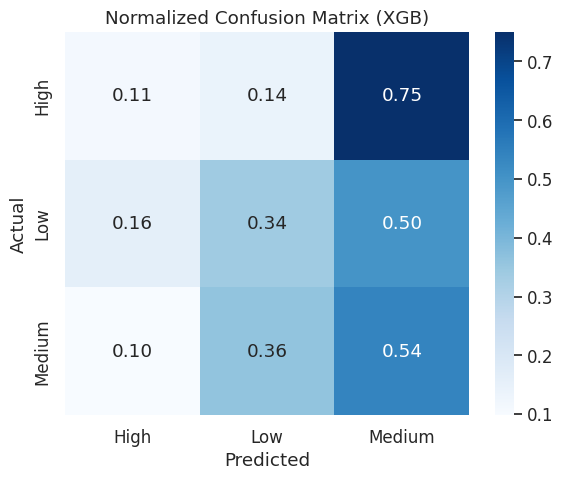


Top misclassification types (true→pred):
Error_Type
Medium→Low     37
Low→Medium     31
High→Medium    27
Low→High       10
Medium→High    10
High→Low        5


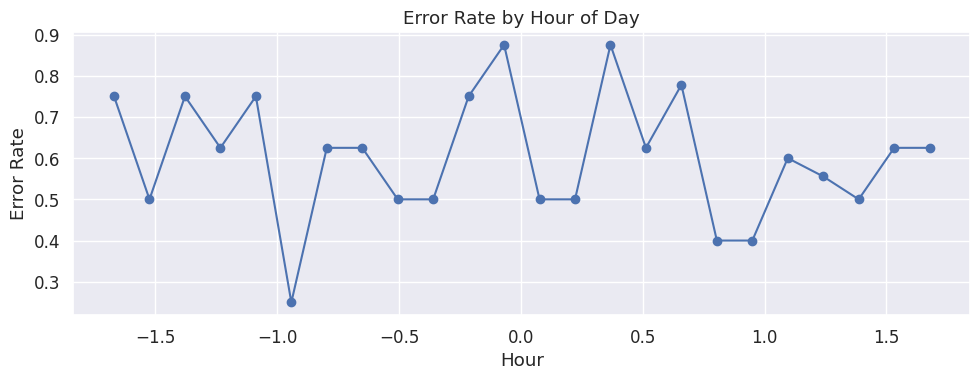

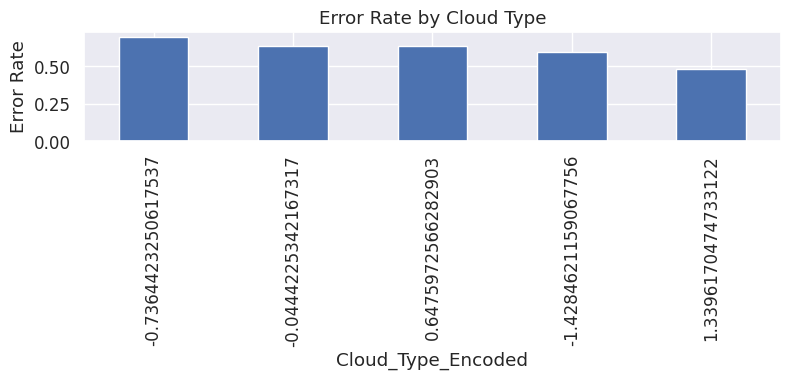

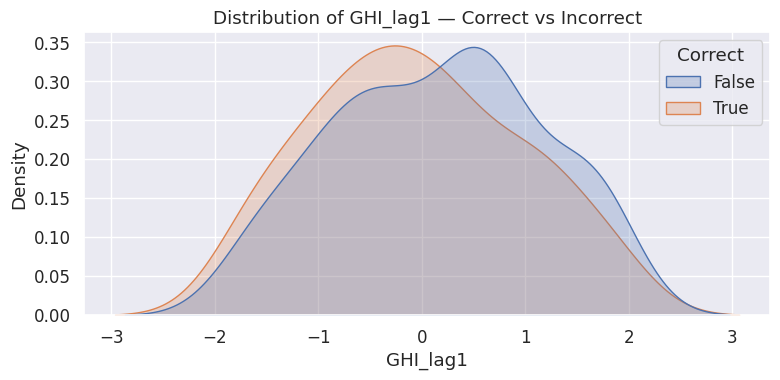

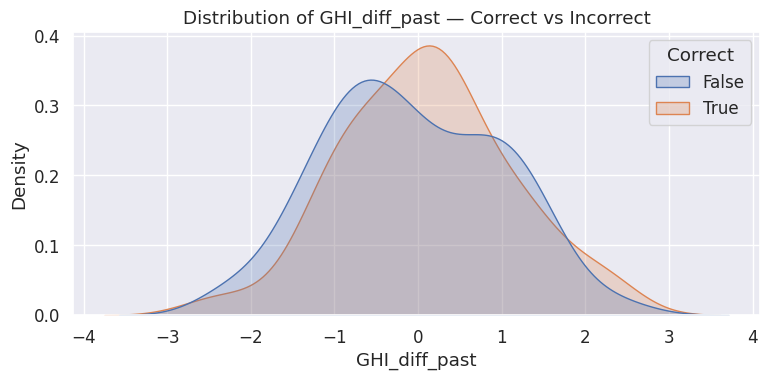

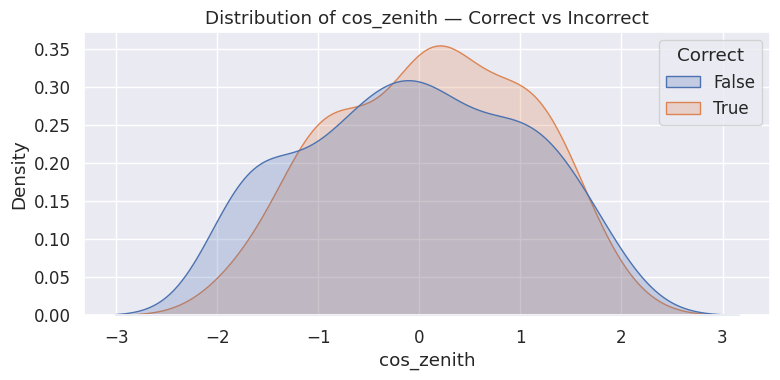

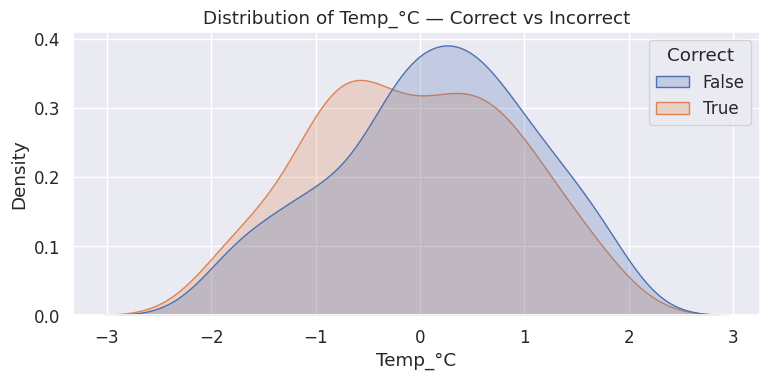

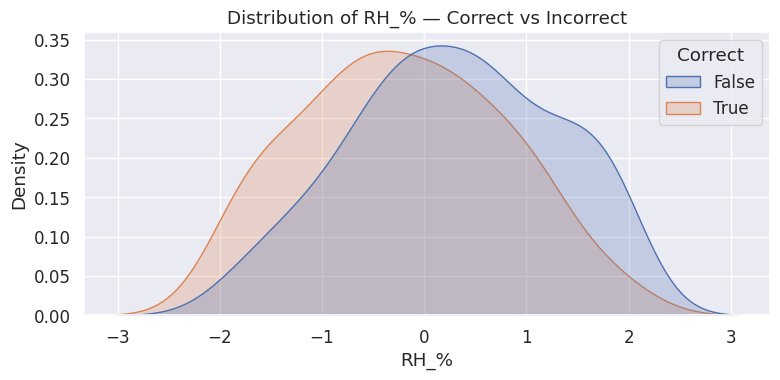

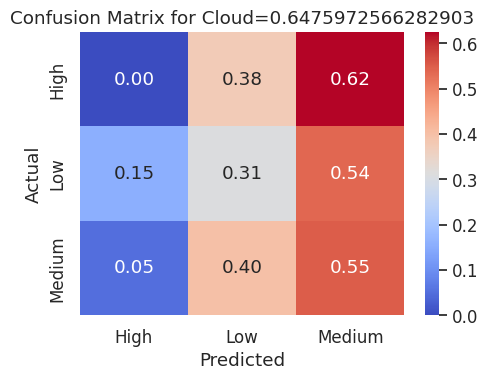

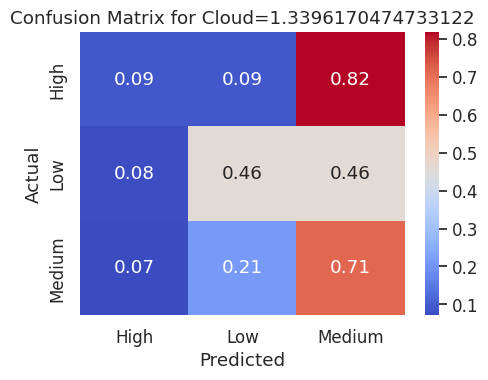

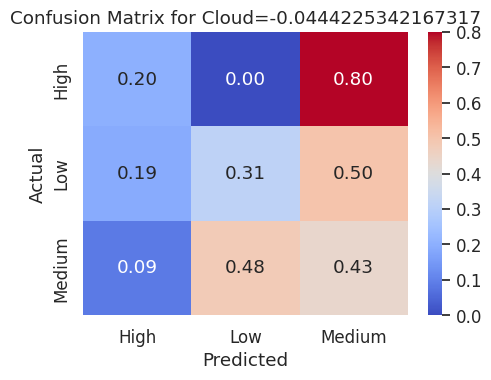

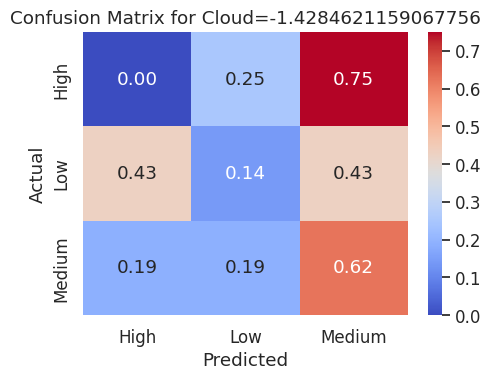

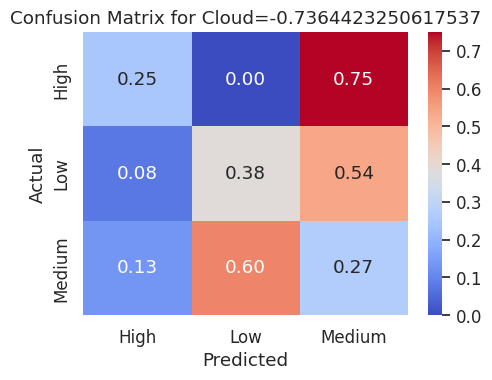


🔍 Sample misclassifications (showing up to 5 per common type):

Error type: Medium→Low (showing 5 examples)


,True_Label,Pred_Label,GHI_lag1,GHI_diff_past,cos_zenith,Temp_°C,RH_%,Cloud_Type_Encoded
3,Medium,Low,0.403670,-0.488295,-0.534691,-1.372394,-0.056403,-0.044423
5,Medium,Low,0.727245,-0.859472,-0.354267,0.804108,1.848926,-0.044423
8,Medium,Low,0.845674,-0.779176,1.722379,0.953376,0.456748,-0.044423
10,Medium,Low,1.616544,-1.382960,-1.010734,1.762818,-0.017095,0.647597
16,Medium,Low,0.225441,-1.267160,0.048337,-0.671083,1.172066,-0.736442



Error type: Low→Medium (showing 5 examples)


,True_Label,Pred_Label,GHI_lag1,GHI_diff_past,cos_zenith,Temp_°C,RH_%,Cloud_Type_Encoded
9,Low,Medium,-0.260804,1.324602,-1.774211,-0.163486,0.437306,0.647597
14,Low,Medium,-0.871977,0.785179,0.166977,0.326214,1.486134,-0.044423
20,Low,Medium,-0.172737,-0.108374,0.582021,-1.158213,1.092284,-1.428462
22,Low,Medium,0.427555,-0.686167,-0.405281,-1.463087,0.892369,1.339617
23,Low,Medium,-0.547006,1.668443,-0.938455,-0.747339,1.422285,1.339617



Error type: High→Medium (showing 5 examples)


,True_Label,Pred_Label,GHI_lag1,GHI_diff_past,cos_zenith,Temp_°C,RH_%,Cloud_Type_Encoded
7,High,Medium,1.002096,-0.109330,-0.147616,1.491579,0.505171,0.647597
15,High,Medium,0.240298,-0.009517,1.090002,0.644768,-0.662609,-1.428462
21,High,Medium,-0.327805,0.533532,0.662900,0.779445,1.848926,-1.428462
32,High,Medium,0.538726,-0.726071,0.005637,-0.238938,0.613946,1.339617
33,High,Medium,-0.492432,0.738785,0.000796,1.198247,-1.329585,-0.736442


In [ ]:
# ============================================================
# Cell 14: Error Analysis
# Purpose: Diagnose where the champion model fails, patterns in misclassification
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

sns.set_context("notebook", font_scale=1.1)

# ---- 0. Choose champion model (must match what was used in Cell 12/11) ----
champion_key = 'xgb'  # or 'rf'; adjust if you want to analyze a different model
model = None
if champion_key.lower() == 'xgb' and 'xgb' in globals():
    model = xgb
elif champion_key.lower() == 'rf' and 'rf' in globals():
    model = rf
elif champion_key.lower() == 'lstm' and 'lstm' in globals():
    model = lstm
else:
    raise RuntimeError(f"Champion model '{champion_key}' not loaded or unknown.")

# ---- 1. Get predictions & build error DataFrame ----
# Prepare test features aligned to model (same logic as evaluation)
def align_for_model(m, X):
    if hasattr(m, "feature_names_in_"):
        return X.reindex(columns=list(m.feature_names_in_), fill_value=0)
    return X.copy()

if champion_key.lower() in ['xgb', 'rf']:
    X_input = align_for_model(model, X_test)
    y_pred = model.predict(X_input)
elif champion_key.lower() == 'lstm':
    # assume X_te_seq was built earlier for LSTM
    y_pred = np.argmax(model.predict(X_te_seq), axis=1)
else:
    raise RuntimeError("Unsupported champion_key for error analysis.")

y_true = np.array(y_test, dtype=int)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_true_decoded = label_encoder.inverse_transform(y_true)

# Build DataFrame for analysis
err_df = X_test.copy().reset_index(drop=True)
err_df['True_Label'] = y_true_decoded
err_df['Pred_Label'] = y_pred_decoded
err_df['Correct'] = err_df['True_Label'] == err_df['Pred_Label']
err_df['Error_Type'] = err_df.apply(lambda r: f"{r['True_Label']}→{r['Pred_Label']}" if not r['Correct'] else "Correct", axis=1)

# ---- 2. Summary statistics ----
print(f"\n🧪 Error Analysis for champion: {champion_key.upper()}")
print("Classification report:")
print(classification_report(y_true_decoded, y_pred_decoded, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_decoded, y_pred_decoded, labels=label_encoder.classes_)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Normalized Confusion Matrix ({champion_key.upper()})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ---- 3. Most common misclassification pairs ----
mis_pairs = err_df[~err_df['Correct']]['Error_Type'].value_counts().head(10)
print("\nTop misclassification types (true→pred):")
print(mis_pairs.to_string())

# ---- 4. Error rate by hour of day (if feature exists) ----
if 'Hour' in err_df.columns:
    summary_by_hour = err_df.groupby('Hour').agg(
        total=('Correct', 'size'),
        correct=('Correct', 'sum')
    )
    summary_by_hour['error_rate'] = 1 - summary_by_hour['correct'] / summary_by_hour['total']
    plt.figure(figsize=(10,4))
    plt.plot(summary_by_hour.index, summary_by_hour['error_rate'], marker='o')
    plt.title("Error Rate by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Error Rate")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---- 5. Error distribution across cloud types (if available) ----
# Prefer the encoded version if present
cloud_col = None
if 'Cloud_Type_Encoded' in err_df.columns:
    cloud_col = 'Cloud_Type_Encoded'
elif 'Cloud_Type' in err_df.columns:
    cloud_col = 'Cloud_Type'

if cloud_col:
    grouped = err_df.groupby(cloud_col).agg(
        total=('Correct', 'size'),
        correct=('Correct', 'sum')
    )
    grouped['error_rate'] = 1 - grouped['correct'] / grouped['total']
    plt.figure(figsize=(8,4))
    grouped['error_rate'].sort_values(ascending=False).plot.bar()
    plt.title("Error Rate by Cloud Type")
    plt.ylabel("Error Rate")
    plt.xlabel(cloud_col)
    plt.tight_layout()
    plt.show()

# ---- 6. Feature distribution for correct vs incorrect ----
key_feats = []
for f in ['GHI_lag1', 'GHI_diff_past', 'cos_zenith', 'Temp_°C', 'RH_%']:
    if f in err_df.columns:
        key_feats.append(f)

for feat in key_feats:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=err_df, x=feat, hue='Correct', common_norm=False, fill=True)
    plt.title(f"Distribution of {feat} — Correct vs Incorrect")
    plt.tight_layout()
    plt.show()

# ---- 7. Confusion conditioned on cloud type (heatmap) ----
if cloud_col:
    for cloud_val in err_df[cloud_col].unique():
        subset = err_df[err_df[cloud_col] == cloud_val]
        if subset.empty:
            continue
        cm_sub = confusion_matrix(subset['True_Label'], subset['Pred_Label'],
                                  labels=label_encoder.classes_)
        cm_sub_norm = cm_sub.astype(float) / np.maximum(cm_sub.sum(axis=1, keepdims=True), 1)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_sub_norm, annot=True, fmt=".2f", cmap='coolwarm',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title(f"Confusion Matrix for Cloud={cloud_val}")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

# ---- 8. Example failure cases ----
print("\n🔍 Sample misclassifications (showing up to 5 per common type):")
top_errors = err_df[~err_df['Correct']]['Error_Type'].value_counts().index.tolist()[:3]
for et in top_errors:
    subset = err_df[err_df['Error_Type'] == et].head(5)
    print(f"\nError type: {et} (showing {len(subset)} examples)")
    display(subset[[ 'True_Label', 'Pred_Label'] + key_feats + ([cloud_col] if cloud_col else [])])


## Final Model Retraining & TimeSeriesSplit CV

Interpretability Analysis

Data splits (chronological): train=697, calib=150, test=150
▶ Trained base XGB on first 70% of data.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✔ Fitted Platt scaling (multinomial logistic) on calibration slice.

📊 Test set performance (final 15%)
Uncalibrated XGB Accuracy:    0.5133, Weighted F1: 0.4573
Calibrated XGB Accuracy:      0.5133, Weighted F1: 0.3483

Uncalibrated classification report:
              precision    recall  f1-score   support

        High       0.20      0.04      0.07        25
         Low       0.48      0.29      0.36        48
      Medium       0.53      0.81      0.64        77

    accuracy                           0.51       150
   macro avg       0.41      0.38      0.36       150
weighted avg       0.46      0.51      0.46       150

Calibrated classification report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        25
         Low       0.00      0.00      0.00        48
      Medium       0.51      1.00      0.68        77

    accuracy                           0.51       150
   macro avg       0.17      0.33      0.23       150
we

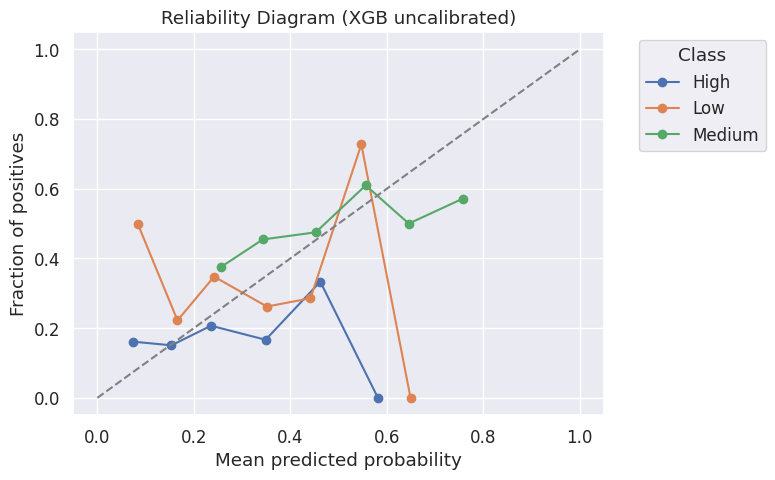

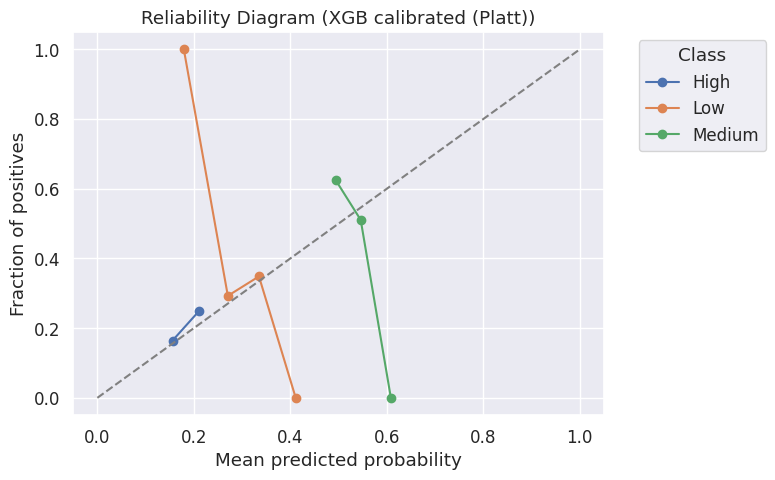


Brier score: uncalibrated=0.2070, calibrated=0.2033

💾 Saved:
 - Base champion (trained on first 70%): platt_xgb_base_train.pkl
 - Platt calibrator: platt_xgb_scaler.pkl


In [ ]:
# ============================================================
# Cell 15 (alt): Final Champion + Manual Platt Scaling with Temporal Hold-out
# Purpose: Train on past, calibrate on immediate future (no leakage), evaluate on later data
# ============================================================

import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    brier_score_loss, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve

sns.set_context("notebook", font_scale=1.1)

# ----- 0. Setup champion -----
champion_key = 'xgb'  # or 'rf'; manual Platt scaling best works with base model that can output decision scores
if champion_key.lower() == 'xgb':
    from xgboost import XGBClassifier
    try:
        base_saved = joblib.load("xgb_advanced_model.pkl")
    except:
        raise RuntimeError("XGBoost model not found; ensure prior cell produced xgb_advanced_model.pkl")
    params = base_saved.get_params()
    champion_base = XGBClassifier(**params)
elif champion_key.lower() == 'rf':
    from sklearn.ensemble import RandomForestClassifier
    try:
        base_saved = joblib.load("rf_model_ghi_class.pkl")
    except:
        raise RuntimeError("Random Forest model not found; ensure prior cell produced rf_model_ghi_class.pkl")
    params = base_saved.get_params()
    champion_base = RandomForestClassifier(**params)
else:
    raise ValueError("champion_key must be 'xgb' or 'rf'.")

# ----- 1. Prepare chronological splits -----
if 'X_final' not in globals() or 'y_final' not in globals():
    raise RuntimeError("X_final / y_final missing. Run Feature Engineering cell first.")

X = X_final.copy()
y = y_final.copy()

# Drop any object columns if present
for col in X.select_dtypes(include=['object']).columns.tolist():
    X.drop(columns=[col], inplace=True)

n = len(X)
train_end = int(0.7 * n)
cal_end = int(0.85 * n)

X_train = X.iloc[:train_end]
y_train = y[:train_end]
X_cal = X.iloc[train_end:cal_end]
y_cal = y[train_end:cal_end]
X_test = X.iloc[cal_end:]
y_test = y[cal_end:]

print(f"Data splits (chronological): train={len(X_train)}, calib={len(X_cal)}, test={len(X_test)}")

# ----- 2. Train base champion on training slice -----
champion_base.fit(X_train, y_train)
print(f"▶ Trained base {champion_key.upper()} on first 70% of data.")

# ----- 3. Fit Platt scaling on calibration slice -----
# For multiclass: use raw margins (before softmax/logits) as input to multinomial logistic regression
if champion_key.lower() == 'xgb':
    # output_margin=True gives raw score per class
    margins_cal = champion_base.predict(X_cal, output_margin=True)
else:
    # RandomForest doesn't provide margin directly; use class probabilities' log-odds as proxy
    probs_cal = champion_base.predict_proba(X_cal)
    # clip to avoid logit inf
    eps = 1e-6
    probs_cal_clipped = np.clip(probs_cal, eps, 1 - eps)
    margins_cal = np.log(probs_cal_clipped / (1 - probs_cal_clipped))  # shape (n_samples, n_classes)

# Fit multinomial logistic regression mapping margins -> true label
platt = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000
)
platt.fit(margins_cal, y_cal)
print("✔ Fitted Platt scaling (multinomial logistic) on calibration slice.")

# ----- 4. Evaluate on test slice (uncalibrated vs calibrated) -----
# Uncalibrated predictions/probs
y_pred_uncal = champion_base.predict(X_test)
proba_uncal = champion_base.predict_proba(X_test)

# Calibrated: compute margins then pass through Platt
if champion_key.lower() == 'xgb':
    margins_test = champion_base.predict(X_test, output_margin=True)
else:
    probs_test = champion_base.predict_proba(X_test)
    probs_test_clipped = np.clip(probs_test, eps, 1 - eps)
    margins_test = np.log(probs_test_clipped / (1 - probs_test_clipped))

proba_calibrated = platt.predict_proba(margins_test)
y_pred_cal = np.argmax(proba_calibrated, axis=1)

# Metrics
acc_uncal = accuracy_score(y_test, y_pred_uncal)
f1_uncal = f1_score(y_test, y_pred_uncal, average='weighted')
acc_cal = accuracy_score(y_test, y_pred_cal)
f1_cal = f1_score(y_test, y_pred_cal, average='weighted')

print("\n📊 Test set performance (final 15%)")
print(f"Uncalibrated {champion_key.upper()} Accuracy:    {acc_uncal:.4f}, Weighted F1: {f1_uncal:.4f}")
print(f"Calibrated {champion_key.upper()} Accuracy:      {acc_cal:.4f}, Weighted F1: {f1_cal:.4f}")

print("\nUncalibrated classification report:")
print(classification_report(y_test, y_pred_uncal, target_names=label_encoder.classes_))
print("Calibrated classification report:")
print(classification_report(y_test, y_pred_cal, target_names=label_encoder.classes_))

# ----- 5. Calibration diagnostics: reliability diagrams & Brier -----
classes = label_encoder.classes_
y_test_bin = label_binarize(y_test, classes=np.arange(len(classes)))

def reliable_plot(y_true_bin, probs, title):
    plt.figure(figsize=(8,5))
    for i, cls in enumerate(classes):
        prob_pos = probs[:, i]
        true_label = y_true_bin[:, i]
        frac_pos, mean_pred = calibration_curve(true_label, prob_pos, n_bins=10, strategy="uniform")
        plt.plot(mean_pred, frac_pos, marker='o', label=cls)
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title(f"Reliability Diagram ({title})")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend(title="Class", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n📉 Reliability diagrams:")
reliable_plot(y_test_bin, proba_uncal, f"{champion_key.upper()} uncalibrated")
reliable_plot(y_test_bin, proba_calibrated, f"{champion_key.upper()} calibrated (Platt)")

def multiclass_brier(y_bin, probs):
    return np.mean([brier_score_loss(y_bin[:, i], probs[:, i]) for i in range(y_bin.shape[1])])

brier_uncal = multiclass_brier(y_test_bin, proba_uncal)
brier_cal = multiclass_brier(y_test_bin, proba_calibrated)
print(f"\nBrier score: uncalibrated={brier_uncal:.4f}, calibrated={brier_cal:.4f}")

# ----- 6. Save artifacts -----
joblib.dump(champion_base, f"platt_{champion_key}_base_train.pkl")
joblib.dump(platt, f"platt_{champion_key}_scaler.pkl")
print("\n💾 Saved:")
print(f" - Base champion (trained on first 70%): platt_{champion_key}_base_train.pkl")
print(f" - Platt calibrator: platt_{champion_key}_scaler.pkl")


Loaded scaler from scaler.pkl
Loaded label encoder from label_encoder.pkl
Using manual Platt-scaled XGBoost pipeline (base + logistic).

Inference output on example inputs:


,Predicted,Confidence,P(High),P(Low),P(Medium)
850,Medium,0.549014,0.153830,0.297156,0.549014
851,Medium,0.561391,0.149980,0.288629,0.561391
852,Medium,0.547953,0.181997,0.270050,0.547953
853,Medium,0.533756,0.168657,0.297588,0.533756
854,Medium,0.497482,0.121629,0.380889,0.497482



SHAP for first example (tree-based):
SHAP explanation summary:


/tmp/ipython-input-2669045028.py:176: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, pd.DataFrame(X_aligned, columns=X_aligned.columns), max_display=top_n, show=False)


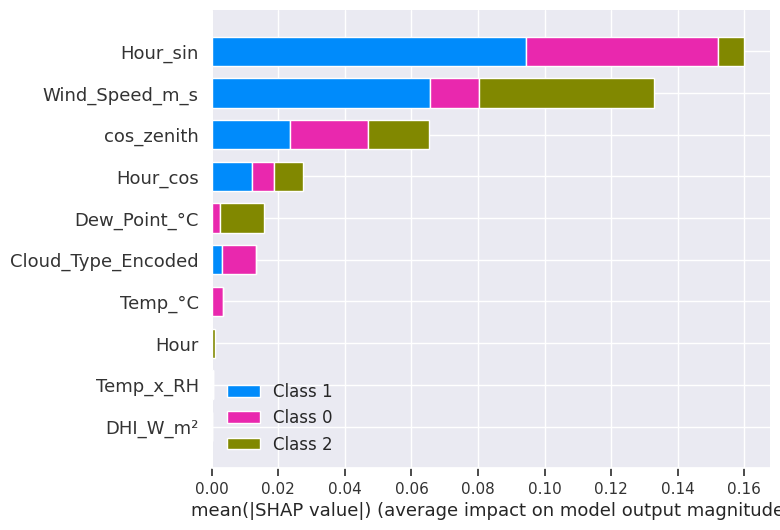

SHAP explain failed: index 40 is out of bounds for axis 0 with size 26


In [ ]:

# ============================================================
# Cell 16: Inference Pipeline for Champion Model
# Purpose: Load saved artifacts, preprocess new data, provide prediction + calibrated probability + optional SHAP explanation
# ============================================================

import joblib
import os
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.1)

# -------- 1. Load available artifacts --------
# Scaler & label encoder (try final versions first)
scaler = None
label_encoder = None
for fname in ["scaler_final.pkl", "scaler.pkl"]:
    if os.path.exists(fname):
        scaler = joblib.load(fname)
        print(f"Loaded scaler from {fname}")
        break
if scaler is None:
    raise FileNotFoundError("Scaler not found. Run preprocessing/feature-engineering cell to create it.")

for fname in ["label_encoder_final.pkl", "label_encoder.pkl"]:
    if os.path.exists(fname):
        label_encoder = joblib.load(fname)
        print(f"Loaded label encoder from {fname}")
        break
if label_encoder is None:
    raise FileNotFoundError("Label encoder not found.")

# Try to load calibrated classifier first, otherwise fallback to manual Platt or base
champion = None
calibrator = None
platt_calibrator = None
use_manual_platt = False

# CalibratedClassifierCV artifact
for model_name in ["final_xgb_calibrated_model.pkl", "final_rf_calibrated_model.pkl"]:
    if os.path.exists(model_name):
        champion = joblib.load(model_name)
        print(f"Using calibrated champion model from {model_name}")
        break

# Manual Platt scaling artifacts (temporal version)
if champion is None:
    # try manual Platt base + logistic
    if os.path.exists("platt_xgb_base_train.pkl") and os.path.exists("platt_xgb_scaler.pkl"):
        from xgboost import XGBClassifier
        champion = joblib.load("platt_xgb_base_train.pkl")
        platt_calibrator = joblib.load("platt_xgb_scaler.pkl")
        use_manual_platt = True
        print("Using manual Platt-scaled XGBoost pipeline (base + logistic).")
    elif os.path.exists("platt_rf_base_train.pkl") and os.path.exists("platt_rf_scaler.pkl"):
        from sklearn.ensemble import RandomForestClassifier
        champion = joblib.load("platt_rf_base_train.pkl")
        platt_calibrator = joblib.load("platt_rf_scaler.pkl")
        use_manual_platt = True
        print("Using manual Platt-scaled Random Forest pipeline (base + logistic).")
    else:
        # Fallback to base champion
        if os.path.exists("final_xgb_base_model.pkl"):
            champion = joblib.load("final_xgb_base_model.pkl")
            print("Using base XGBoost champion (no calibration).")
        elif os.path.exists("final_rf_base_model.pkl"):
            champion = joblib.load("final_rf_base_model.pkl")
            print("Using base Random Forest champion (no calibration).")
        elif os.path.exists("xgb_advanced_model.pkl"):
            champion = joblib.load("xgb_advanced_model.pkl")
            print("Using saved XGBoost model (un-calibrated).")
        elif os.path.exists("rf_model_ghi_class.pkl"):
            champion = joblib.load("rf_model_ghi_class.pkl")
            print("Using saved Random Forest model (un-calibrated).")
        else:
            raise FileNotFoundError("No champion model file found.")

# -------- 2. Preprocessing helper --------
def preprocess_new_data(df_new):
    """
    Aligns new raw feature DataFrame to training schema: fills missing cols, drops unexpected.
    Applies scaler. Returns scaled array and aligned DataFrame.
    """
    # Align columns to scaler / training feature names
    if hasattr(scaler, "feature_names_in_"):
        expected_cols = list(scaler.feature_names_in_)
    else:
        # fallback to whatever champion expects
        if hasattr(champion, "feature_names_in_"):
            expected_cols = list(champion.feature_names_in_)
        else:
            expected_cols = df_new.select_dtypes(include=[np.number]).columns.tolist()

    X_aligned = df_new.reindex(columns=expected_cols, fill_value=0)
    X_scaled = scaler.transform(X_aligned)
    return X_scaled, X_aligned

# -------- 3. Prediction wrapper --------
def predict_ghi_category(df_new):
    """
    Input: new data DataFrame with same feature names before scaling.
    Output: DataFrame with predicted class, probability (calibrated if available), and raw scores.
    """
    X_scaled, X_aligned = preprocess_new_data(df_new)
    # If the model is a calibrated classifier, predict_proba is calibrated already
    if use_manual_platt:
        # Get base probabilities or margins
        if hasattr(champion, "predict"):
            # for XGBoost, we can get raw margin then apply Platt
            try:
                margins = champion.predict(df_new.reindex(columns=X_aligned.columns, fill_value=0), output_margin=True)
            except Exception:
                probs = champion.predict_proba(X_scaled)
                eps = 1e-6
                probs_clipped = np.clip(probs, eps, 1 - eps)
                margins = np.log(probs_clipped / (1 - probs_clipped))
        else:
            margins = champion.predict_proba(X_scaled)  # fallback
        calibrated_proba = platt_calibrator.predict_proba(margins)
        pred_idx = np.argmax(calibrated_proba, axis=1)
        pred_label = label_encoder.inverse_transform(pred_idx)
        confidence = calibrated_proba.max(axis=1)
        raw_proba = champion.predict_proba(X_scaled) if hasattr(champion, "predict_proba") else None
    else:
        proba = champion.predict_proba(X_scaled)
        pred_idx = np.argmax(proba, axis=1)
        pred_label = label_encoder.inverse_transform(pred_idx)
        confidence = proba.max(axis=1)
        calibrated_proba = proba
        raw_proba = proba

    out = pd.DataFrame({
        "Predicted": pred_label,
        "Confidence": confidence
    }, index=df_new.index)

    # attach full probability vector
    for i, cls in enumerate(label_encoder.classes_):
        out[f"P({cls})"] = calibrated_proba[:, i]

    return out, X_aligned

# -------- 4. Optional: SHAP explanation for a single sample --------
def shap_explain(sample_df, model=champion, background_samples=None, top_n=10):
    """
    Provide SHAP explanation for one or more samples. sample_df should be raw (pre-scaling) DataFrame.
    """
    X_scaled, X_aligned = preprocess_new_data(sample_df)
    # Build background if not provided
    if background_samples is None:
        # sample from training data
        if 'X_train' in globals():
            bg = X_train.sample(n=min(200, len(X_train)), random_state=42)
            if hasattr(scaler, "transform"):
                bg_scaled = scaler.transform(bg.reindex(columns=X_aligned.columns, fill_value=0))
                try:
                    explainer = shap.Explainer(model, bg_scaled)
                    shap_values = explainer(X_scaled)
                except Exception:
                    explainer = shap.Explainer(model, bg)
                    shap_values = explainer(X_aligned)
            else:
                explainer = shap.Explainer(model, bg)
                shap_values = explainer(X_aligned)
        else:
            raise RuntimeError("No training data in scope to sample background for SHAP.")
    else:
        explainer = shap.Explainer(model, background_samples)
        shap_values = explainer(X_scaled)

    # Summary for the sample(s)
    print("SHAP explanation summary:")
    shap.summary_plot(shap_values, pd.DataFrame(X_aligned, columns=X_aligned.columns), max_display=top_n, show=False)
    plt.tight_layout()
    plt.show()

    # Force dependence for top feature
    if hasattr(shap_values, 'values'):
        feature_idx = np.argmax(np.mean(np.abs(shap_values.values), axis=0))
        feat = X_aligned.columns[feature_idx]
        print(f"\nDependence plot for top feature: {feat}")
        try:
            shap.dependence_plot(feat, shap_values.values, pd.DataFrame(X_aligned, columns=X_aligned.columns), show=False)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Dependence plot failed:", e)

# -------- 5. Example usage --------
# Replace this with your actual new/raw data (must include same columns prior to scaling)
# Example: take first 5 rows from test split as 'new' inputs
example_raw = X_test.iloc[:5].copy()  # assuming X_test available from previous cells
pred_df, aligned = predict_ghi_category(example_raw)
print("\nInference output on example inputs:")
display(pred_df)

# If tree model, show SHAP for first sample
try:
    print("\nSHAP for first example (tree-based):")
    shap_explain(example_raw.iloc[[0]])
except Exception as e:
    print("SHAP explain failed:", e)


##  Deployment Prototype with FastAPI

In [ ]:
# ============================================================
# Cell 17: Batch Inference + Logging and CSV Export
# Purpose: Run batch predictions, optionally evaluate if true labels available, and persist results
# ============================================================

import os
import time
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ---- Helpers: reuse from Cell 16 if present, else redefine minimal ----
needs_redefine = False
try:
    predict_ghi_category  # exists
except NameError:
    needs_redefine = True

if needs_redefine:
    # Fallback minimal preprocessing/prediction assuming champion, scaler, label_encoder are loaded
    def preprocess_new_data(df_new):
        if hasattr(scaler, "feature_names_in_"):
            expected_cols = list(scaler.feature_names_in_)
        else:
            if hasattr(champion, "feature_names_in_"):
                expected_cols = list(champion.feature_names_in_)
            else:
                expected_cols = df_new.select_dtypes(include=[np.number]).columns.tolist()
        X_aligned = df_new.reindex(columns=expected_cols, fill_value=0)
        X_scaled = scaler.transform(X_aligned)
        return X_scaled, X_aligned

    def predict_ghi_category(df_new):
        X_scaled, X_aligned = preprocess_new_data(df_new)
        if 'use_manual_platt' in globals() and use_manual_platt and platt_calibrator is not None:
            # manual Platt path
            if hasattr(champion, "predict"):
                try:
                    margins = champion.predict(df_new.reindex(columns=X_aligned.columns, fill_value=0), output_margin=True)
                except Exception:
                    probs = champion.predict_proba(X_scaled)
                    eps = 1e-6
                    probs_clipped = np.clip(probs, eps, 1 - eps)
                    margins = np.log(probs_clipped / (1 - probs_clipped))
            else:
                margins = champion.predict_proba(X_scaled)
            calibrated_proba = platt_calibrator.predict_proba(margins)
            pred_idx = np.argmax(calibrated_proba, axis=1)
            pred_label = label_encoder.inverse_transform(pred_idx)
            confidence = calibrated_proba.max(axis=1)
            proba_full = calibrated_proba
        else:
            proba = champion.predict_proba(X_scaled)
            pred_idx = np.argmax(proba, axis=1)
            pred_label = label_encoder.inverse_transform(pred_idx)
            confidence = proba.max(axis=1)
            proba_full = proba

        out = pd.DataFrame({
            "Predicted": pred_label,
            "Confidence": confidence
        }, index=df_new.index)
        for i, cls in enumerate(label_encoder.classes_):
            out[f"P({cls})"] = proba_full[:, i]
        return out, X_aligned

# ---- Main batch inference function ----
def batch_inference(df_new, true_label_col=None, output_csv="batch_predictions.csv", append=False):
    """
    Run predictions on a batch of raw input rows.
    df_new: DataFrame of raw features (before scaling/encoding).
    true_label_col: optional column name in df_new with ground truth integer labels or class names.
    output_csv: path to write predictions.
    append: if True and file exists, append; otherwise overwrite/create.
    Returns: tuple (predictions_df, metrics_dict or None)
    """
    start_time = time.time()
    # Separate true labels if provided
    y_true = None
    if true_label_col is not None and true_label_col in df_new.columns:
        raw_true = df_new[true_label_col]
        # if string labels, convert to encoded
        if raw_true.dtype == object or raw_true.dtype.name.startswith("category"):
            try:
                y_true = label_encoder.transform(raw_true)
            except Exception:
                y_true = raw_true.values  # fallback
        else:
            y_true = raw_true.values

        df_input = df_new.drop(columns=[true_label_col]).copy()
    else:
        df_input = df_new.copy()

    # Predict
    preds_df, aligned = predict_ghi_category(df_input)

    # Attach timestamp and true label if any
    preds_df = preds_df.reset_index(drop=True)
    df_input = df_input.reset_index(drop=True)
    result = pd.concat([df_input, preds_df], axis=1)
    result["Inference_Timestamp"] = datetime.utcnow().isoformat()
    if y_true is not None:
        # decode true if integer to human label
        try:
            true_decoded = label_encoder.inverse_transform(y_true.astype(int))
        except Exception:
            true_decoded = y_true
        result["True_Label"] = true_decoded

    # Metrics if ground truth available
    metrics = None
    if y_true is not None:
        # Convert predicted labels to encoded for comparison
        y_pred_enc = label_encoder.transform(result["Predicted"])
        # If y_true is already encoded integers, use directly; else attempt mapping
        y_true_enc = y_true
        acc = accuracy_score(y_true_enc, y_pred_enc)
        f1w = f1_score(y_true_enc, y_pred_enc, average='weighted')
        metrics = {
            "accuracy": acc,
            "weighted_f1": f1w,
            "classification_report": classification_report(
                y_true_enc, y_pred_enc, target_names=label_encoder.classes_, output_dict=True
            )
        }
        print(f"\n🧪 Batch Evaluation: accuracy={acc:.4f}, weighted_f1={f1w:.4f}")
        print(classification_report(y_true_enc, y_pred_enc, target_names=label_encoder.classes_))

    # Save to CSV
    mode = "a" if (append and os.path.exists(output_csv)) else "w"
    header = not (append and os.path.exists(output_csv))
    result.to_csv(output_csv, mode=mode, index=False, header=header)
    print(f"\n💾 Saved batch predictions to '{output_csv}' (append={append})")
    elapsed = time.time() - start_time
    print(f"⏱ Batch inference took {elapsed:.2f}s for {len(df_new)} samples.")

    # Simple distribution summary
    print("\n📊 Prediction distribution:")
    print(result["Predicted"].value_counts(normalize=True).round(3).to_string())

    return result, metrics

# ---- Example usage ----
# Simulate batch: use test set (needs the original true category if available)
if 'X_test' in globals():
    # If y_test is encoded integer, convert to class name column
    example_batch = X_test.copy()
    # If you have the true label column (e.g., GHI_Category), attach it for evaluation
    # Here we assume y_test (encoded) is available
    try:
        example_batch["True_Label"] = label_encoder.inverse_transform(y_test)
    except:
        example_batch["True_Label"] = y_test

    preds, metrics = batch_inference(
        example_batch,
        true_label_col="True_Label",
        output_csv="batch_preds_test.csv",
        append=False
    )



🧪 Batch Evaluation: accuracy=0.5133, weighted_f1=0.3483
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        25
         Low       0.00      0.00      0.00        48
      Medium       0.51      1.00      0.68        77

    accuracy                           0.51       150
   macro avg       0.17      0.33      0.23       150
weighted avg       0.26      0.51      0.35       150


💾 Saved batch predictions to 'batch_preds_test.csv' (append=False)
⏱ Batch inference took 0.10s for 150 samples.

📊 Prediction distribution:
Predicted
Medium    1.0


In [ ]:
import joblib
from sklearn.preprocessing import LabelEncoder

rf = joblib.load("rf_model_ghi_class.pkl")
xgb = joblib.load("xgb_advanced_model.pkl")
label_encoder = joblib.load("label_encoder.pkl")
# If you have optimized DNN/LSTM saved:
from tensorflow.keras.models import load_model
final_dnn = load_model("final_optimized_dnn_timeaware.keras")  # or optimized_dnn_ghi_classifier.keras if exists
opt_lstm = load_model("optimized_lstm_ghi_classifier.keras")
# Reload test data (X_test, y_test, X_te_seq, y_te_seq) from earlier preprocessing
